In [1]:
import pyarrow.feather as feather
import numpy as np
import pandas as pd
import os
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from collections import Counter

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm,trange 
from pandas.tseries.offsets import Day, YearEnd, YearBegin
from datetime import datetime, timedelta

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,PredefinedSplit
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
from scipy.stats import reciprocal, uniform
import heapq
import yfinance as yf


In [2]:
pd.options.display.max_columns = 10 # 最大显示列数
pd.options.display.max_rows = 10 # 最大显示行数

## read character data

In [110]:
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
directory_path = os.getcwd()

In [111]:
# raw_df=feather.read_feather('/Users/shuxianhong/Desktop/Summer Project/chars60_raw_imputed.feather')
raw_df = pd.read_feather(os.path.join(directory_path, 'chars60_raw_imputed.feather'))

In [112]:
raw_df.columns

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'adm', 'bm_ia',
       'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m',
       'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3',
       'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me',
       'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore',
       'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho',
       'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni',
       'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe',
       'rsup', 'sgr', 'sp', 'date', 'ffi49'],
      dtype='object')

In [113]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

['adm',
 'bm_ia',
 'mom12m',
 'mom36m',
 'mom60m',
 'mom6m',
 'seas1a',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cashdebt',
 'chcsho',
 'chpm',
 'chtx',
 'gma',
 'grltnoa',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr']

In [114]:
raw_df['year'] = raw_df['date'].dt.year
raw_df = raw_df[raw_df['year'] >= 1972]
raw_df = raw_df.drop(['year'], axis=1)

In [115]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

no missing value!

In [116]:
raw_df

,gvkey,permno,sic,ret,exchcd,shrcd,adm,bm_ia,herf,hire,...,rd_sale,rdm,rna,roa,roe,rsup,sgr,sp,date,ffi49
136,1010,10006,3743,0.004854,1.0,10.0,0.000006,0.000046,0.718884,-0.049123,...,0.007357,0.000009,0.106823,-0.000011,0.096217,0.000047,0.042217,0.001158,1972-01-31,25
137,1010,10006,3743,-0.007729,1.0,10.0,0.000006,0.000042,0.718884,-0.049123,...,0.007357,0.000008,0.106823,-0.000011,0.096217,0.000047,0.042217,0.001152,1972-02-29,25
138,1010,10006,3743,-0.068966,1.0,10.0,0.000006,0.000059,0.718884,-0.049123,...,0.007357,0.000009,0.106823,-0.000011,0.096217,0.000048,0.042217,0.001175,1972-03-31,25
139,1010,10006,3743,-0.068783,1.0,10.0,0.000007,0.000122,0.718884,-0.049123,...,0.007357,0.000009,0.106823,-0.000011,0.096217,0.000051,0.042217,0.001262,1972-04-30,25
140,1010,10006,3743,0.025000,1.0,10.0,0.000006,0.000164,0.718079,-0.099815,...,0.006949,0.000009,0.090818,0.000007,0.080707,-0.000004,-0.003038,0.001351,1972-05-31,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551140,260778,90272,6324,-0.057476,1.0,11.0,0.000005,-0.000689,0.092306,0.348315,...,0.000000,0.000000,0.053990,0.015538,0.043113,0.000146,0.272945,0.001559,2019-08-31,46
551141,260778,90272,6324,-0.042735,1.0,11.0,0.000006,-0.000671,0.092306,0.348315,...,0.000000,0.000000,0.053990,0.015538,0.043113,0.000155,0.272945,0.001654,2019-09-30,46
551142,260778,90272,6324,0.144423,1.0,11.0,0.000006,-0.000657,0.092306,0.348315,...,0.000000,0.000000,0.053990,0.015538,0.043113,0.000162,0.272945,0.001728,2019-10-31,46
551143,260778,90272,6324,0.085873,1.0,11.0,0.000006,-0.000699,0.092306,0.348315,...,0.000000,0.000000,0.067523,0.018249,0.054882,0.000159,0.380853,0.001668,2019-11-30,46


## read macro data

In [117]:
# macro_df = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/Macro.csv')

macro_df = pd.read_csv(os.path.join(directory_path,'Macro.csv'))
macro_df = macro_df[macro_df['yyyymm']>=197201]

In [118]:
macro_df

,yyyymm,b/m,tbl,ntis,svar,d/p,e/p,dfy,tms
1212,197201,0.635357,0.0338,0.033075,0.000494,1.529644,1.258123,0.0104,0.0268
1213,197202,0.617586,0.0320,0.033030,0.000284,1.540497,1.266209,0.0096,0.0282
1214,197203,0.645902,0.0373,0.031723,0.000545,1.543056,1.266019,0.0100,0.0240
1215,197204,0.636784,0.0371,0.032492,0.000383,1.544956,1.263950,0.0094,0.0244
1216,197205,0.632442,0.0369,0.030657,0.000769,1.552395,1.267456,0.0093,0.0228
...,...,...,...,...,...,...,...,...,...
1795,202008,0.235975,0.0010,-0.008504,0.000743,1.772309,1.550421,0.0102,0.0055
1796,202009,0.241482,0.0011,-0.005698,0.004907,1.756971,1.534527,0.0105,0.0057
1797,202010,0.253146,0.0010,-0.001895,0.003661,1.746197,1.528413,0.0109,0.0069
1798,202011,0.226352,0.0009,-0.005262,0.002492,1.791974,1.578931,0.0100,0.0078


## merge macro & char

In [119]:
raw_df['yyyymm'] = raw_df['date'].dt.strftime('%Y%m').apply(int)
total_df = pd.merge(raw_df, macro_df, how='inner',on='yyyymm')
total_df.drop(columns='yyyymm',inplace=True)
total_df

,gvkey,permno,sic,ret,exchcd,shrcd,adm,bm_ia,herf,hire,...,date,ffi49,b/m,tbl,ntis,svar,d/p,e/p,dfy,tms
0,1010,10006,3743,0.004854,1.0,10.0,0.000006,0.000046,0.718884,-0.049123,...,1972-01-31,25,0.635357,0.0338,0.033075,0.000494,1.529644,1.258123,0.0104,0.0268
1,1040,15763,3949,0.111399,1.0,10.0,0.000037,-0.000224,0.163326,0.033872,...,1972-01-31,6,0.635357,0.0338,0.033075,0.000494,1.529644,1.258123,0.0104,0.0268
2,1043,18980,5040,0.080000,1.0,11.0,0.000037,0.000088,1.000000,-0.092000,...,1972-01-31,42,0.635357,0.0338,0.033075,0.000494,1.529644,1.258123,0.0104,0.0268
3,1045,21020,4512,0.042945,1.0,11.0,0.000031,-0.000685,0.062520,-0.033342,...,1972-01-31,41,0.635357,0.0338,0.033075,0.000494,1.529644,1.258123,0.0104,0.0268
4,1070,21549,3714,0.191489,2.0,10.0,0.000037,0.001247,0.248527,0.000000,...,1972-01-31,23,0.635357,0.0338,0.033075,0.000494,1.529644,1.258123,0.0104,0.0268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462751,188255,12981,2430,0.048165,1.0,11.0,0.000025,0.000052,0.262476,0.000000,...,2013-12-31,17,0.304408,0.0007,0.012144,0.000746,1.722817,1.265919,0.0076,0.0371
462752,189491,13035,3561,0.001157,1.0,11.0,0.000003,-0.000044,0.157914,0.016000,...,2013-12-31,21,0.304408,0.0007,0.012144,0.000746,1.722817,1.265919,0.0076,0.0371
462753,199356,13168,7370,-0.062160,3.0,11.0,0.000015,-0.000239,0.267858,0.260000,...,2013-12-31,36,0.304408,0.0007,0.012144,0.000746,1.722817,1.265919,0.0076,0.0371
462754,260774,90199,6500,0.084983,1.0,11.0,0.000005,-0.000063,0.476217,0.088235,...,2013-12-31,47,0.304408,0.0007,0.012144,0.000746,1.722817,1.265919,0.0076,0.0371


In [120]:
raw_tf = total_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

In [121]:
total_df.shrcd.nunique()

2

## information variable

- stock indicator: gvkey, permno
- time: datadate, date, year ('datadate' is the available time for data and 'date' is the date of return)
- industry: sic, ffi49
- exchange info: exchcd (exchange code), shrcd (share code, eg: 1=ordinary common share)
- return: ret: the dividend adjusted return (we also provide original return and return without dividend, you can keep them by modifing impute_rank_output_bchmk.py)
- market equity: me/rank_me


In [122]:
# need to turn some variables to dummy variables
def get_dummy_col(target_df, col_names):
    """turn the cols into multiple cols containing dummy variables, then drop the original columns

    Args:
        target_df (pandas dataframe): target dataframe
        col_names (list): list of columns that need to be turned into dummy variables
    """
    for col in col_names:        
        tmp_dummies = pd.get_dummies(target_df[col]).rename(columns=lambda x: f'{col}_' + str(x))
        target_df = pd.concat([target_df, tmp_dummies], axis=1)
        target_df.drop(col, inplace=True, axis = 1)
    return target_df 
dummy_col_list = ['ffi49'] # do we really need shrcd & exchcd? drop these two and only consider ffi49 as dummy
total_df = get_dummy_col(total_df, dummy_col_list)

In [123]:
total_df.set_index('date', inplace=True)
total_df.sort_values(by=['permno','date'])
total_df

,gvkey,permno,sic,ret,exchcd,shrcd,adm,bm_ia,herf,hire,...,ffi49_40,ffi49_41,ffi49_42,ffi49_43,ffi49_44,ffi49_45,ffi49_46,ffi49_47,ffi49_48,ffi49_49
date,,,,,,,,,,,,,,,,,,,,,
1972-01-31,1010,10006,3743,0.004854,1.0,10.0,0.000006,0.000046,0.718884,-0.049123,...,0,0,0,0,0,0,0,0,0,0
1972-01-31,1040,15763,3949,0.111399,1.0,10.0,0.000037,-0.000224,0.163326,0.033872,...,0,0,0,0,0,0,0,0,0,0
1972-01-31,1043,18980,5040,0.080000,1.0,11.0,0.000037,0.000088,1.000000,-0.092000,...,0,0,1,0,0,0,0,0,0,0
1972-01-31,1045,21020,4512,0.042945,1.0,11.0,0.000031,-0.000685,0.062520,-0.033342,...,0,1,0,0,0,0,0,0,0,0
1972-01-31,1070,21549,3714,0.191489,2.0,10.0,0.000037,0.001247,0.248527,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,188255,12981,2430,0.048165,1.0,11.0,0.000025,0.000052,0.262476,0.000000,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,189491,13035,3561,0.001157,1.0,11.0,0.000003,-0.000044,0.157914,0.016000,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,199356,13168,7370,-0.062160,3.0,11.0,0.000015,-0.000239,0.267858,0.260000,...,0,0,0,0,0,0,0,0,0,0


In [124]:
total_df.columns

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'adm', 'bm_ia',
       'herf', 'hire',
       ...
       'ffi49_40', 'ffi49_41', 'ffi49_42', 'ffi49_43', 'ffi49_44', 'ffi49_45',
       'ffi49_46', 'ffi49_47', 'ffi49_48', 'ffi49_49'],
      dtype='object', length=123)

<AxesSubplot:xlabel='date'>

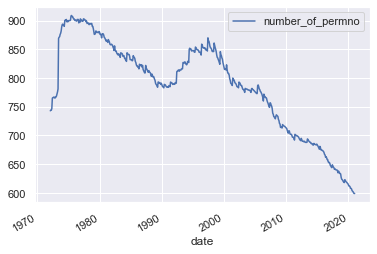

In [125]:
each_month_permno_num = pd.DataFrame(Counter(total_df.reset_index().date).items(), columns=['date', 'number_of_permno'])
each_month_permno_num.plot(x='date', y='number_of_permno')

In [126]:
# set character features list
features_list = total_df.columns.tolist()
remove_list = {'gvkey', 'permno', 'ret','sic','exchcd','shrcd'}
features_list = [ele for ele in features_list if ele not in remove_list]
len(features_list)

117

In [127]:
print(features_list)

['adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3', 'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me', 'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp', 'b/m', 'tbl', 'ntis', 'svar', 'd/p', 'e/p', 'dfy', 'tms', 'ffi49_1', 'ffi49_2', 'ffi49_3', 'ffi49_4', 'ffi49_5', 'ffi49_6', 'ffi49_7', 'ffi49_8', 'ffi49_9', 'ffi49_10', 'ffi49_11', 'ffi49_12', 'ffi49_13', 'ffi49_14', 'ffi49_15', 'ffi49_16', 'ffi49_17', 'ffi49_18', 'ffi49_19', 'ffi49_21', 'ffi49_22', 'ffi49_23', 'ffi49_24', 'ffi49_25', 'ffi49_26', 'ffi49_27', 'ffi49_28', 'ffi49_29', 'ffi49_30', 'ffi49_31', 'ffi49_32', 'ffi49_33', 'ffi49_34', 'ffi49_35', 'ffi49_36', 'ffi49_37

## check distribution and correlation 

C:\Users\haosh\AppData\Local\Temp\ipykernel_12676\3608439455.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  total_df[features_list[:69]].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);


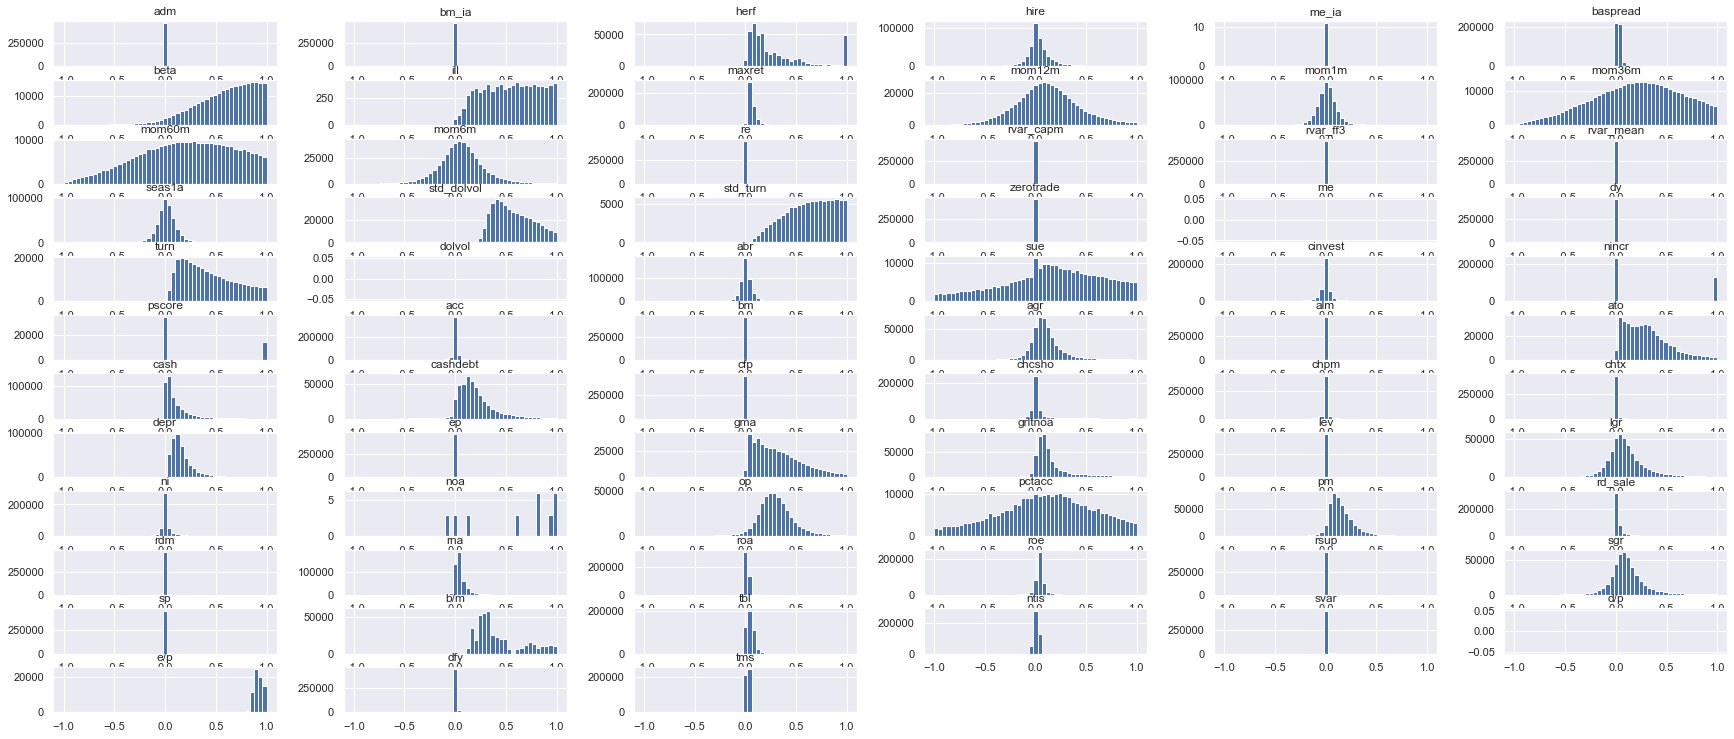

In [25]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
total_df[features_list[:69]].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);

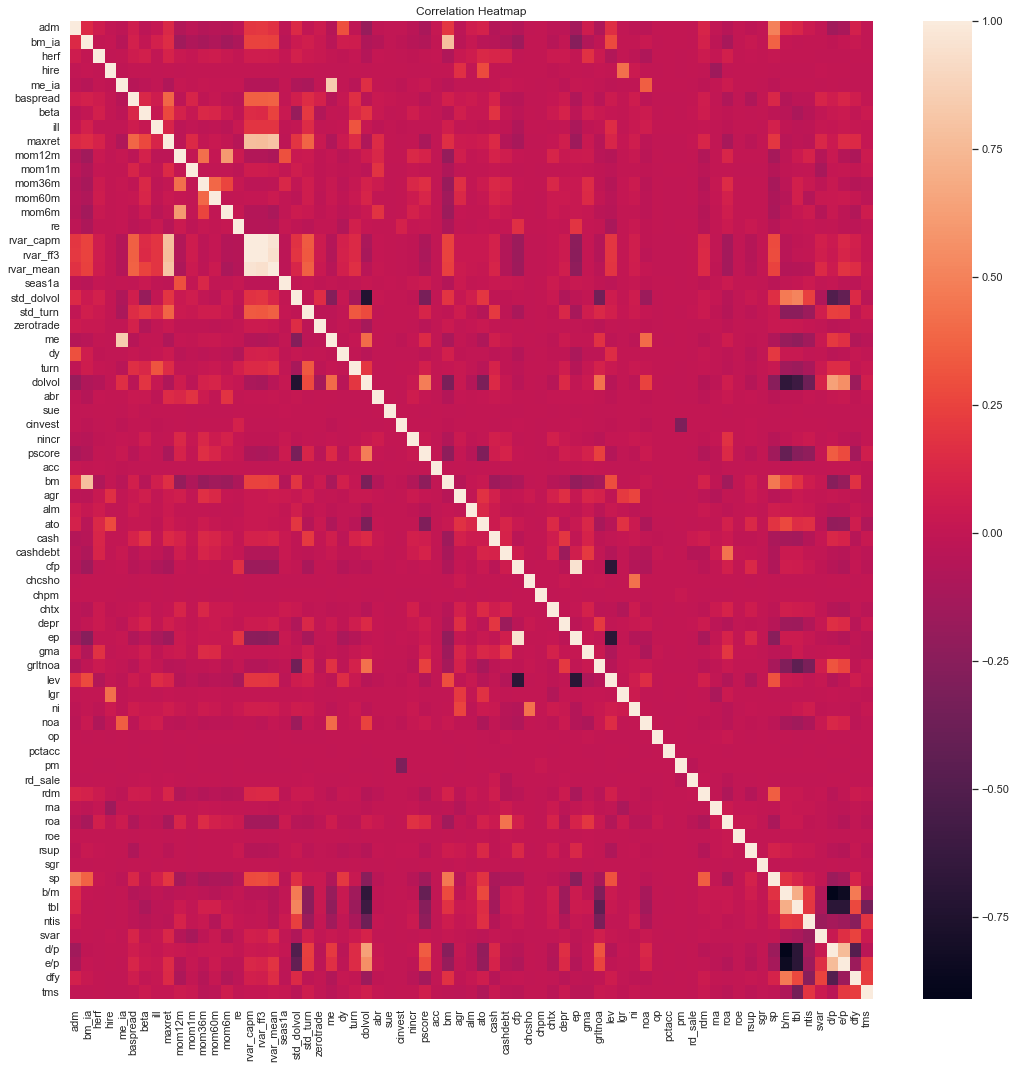

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(figsize = (18,18))
sns.heatmap(data=total_df[features_list[:69]].corr())
plt.title('Correlation Heatmap')
plt.show()
plt.gcf().clear()

In [ ]:
table_for_interaction = total_df[features_list[:69]]
single_features = features_list[:61]
macro_features = features_list[61:69]

interaction_table = pd.DataFrame(data = None, index = table_for_interaction.index)
for i in single_features:
    for j in macro_features:
        interaction_table[i + '+' + j] = table_for_interaction[i] * table_for_interaction[j]

In [129]:
interaction_table

,adm+b/m,adm+tbl,adm+ntis,adm+svar,adm+d/p,adm+e/p,adm+dfy,adm+tms,bm_ia+b/m,bm_ia+tbl,...,sgr+dfy,sgr+tms,sp+b/m,sp+tbl,sp+ntis,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
date,,,,,,,,,,,,,,,,,,,,,
1972-01-31,3.791261e-06,2.016892e-07,1.973637e-07,2.949077e-09,0.000009,0.000008,6.205821e-08,1.599192e-07,0.000029,1.568905e-06,...,0.000439,0.001131,0.000736,3.913216e-05,3.829292e-05,5.721860e-07,0.001771,0.001457,1.204066e-05,0.000031
1972-01-31,2.352534e-05,1.251511e-06,1.224671e-06,1.829946e-08,0.000057,0.000047,3.850805e-07,9.923227e-07,-0.000142,-7.572472e-06,...,0.000560,0.001444,0.000466,2.476997e-05,2.423874e-05,3.621837e-07,0.001121,0.000922,7.621528e-06,0.000020
1972-01-31,2.352534e-05,1.251511e-06,1.224671e-06,1.829946e-08,0.000057,0.000047,3.850805e-07,9.923227e-07,0.000056,2.985817e-06,...,-0.000202,-0.000520,0.000948,5.044274e-05,4.936093e-05,7.375680e-07,0.002283,0.001878,1.552084e-05,0.000040
1972-01-31,1.961296e-05,1.043379e-06,1.021002e-06,1.525617e-08,0.000047,0.000039,3.210396e-07,8.272944e-07,-0.000435,-2.313986e-05,...,0.001005,0.002590,0.000728,3.870571e-05,3.787562e-05,5.659505e-07,0.001752,0.001441,1.190945e-05,0.000031
1972-01-31,2.352534e-05,1.251511e-06,1.224671e-06,1.829946e-08,0.000057,0.000047,3.850805e-07,9.923227e-07,0.000792,4.214284e-05,...,0.001467,0.003781,0.004318,2.296989e-04,2.247727e-04,3.358631e-06,0.010395,0.008550,7.067657e-05,0.000182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,7.535672e-06,1.732861e-08,3.006245e-07,1.845586e-08,0.000043,0.000031,1.881392e-07,9.184165e-07,0.000016,3.672299e-08,...,0.000443,0.002164,0.000154,3.535172e-07,6.132974e-06,3.765140e-07,0.000870,0.000639,3.838187e-06,0.000019
2013-12-31,8.049202e-07,1.850950e-09,3.211110e-08,1.971357e-09,0.000005,0.000003,2.009603e-08,9.810034e-08,-0.000014,-3.109081e-08,...,-0.000186,-0.000910,0.000179,4.104986e-07,7.121512e-06,4.372021e-07,0.001010,0.000742,4.456841e-06,0.000022
2013-12-31,4.666211e-06,1.073016e-08,1.861516e-07,1.142817e-08,0.000026,0.000019,1.164989e-07,5.686984e-07,-0.000073,-1.672231e-07,...,0.009540,0.046572,0.000023,5.266724e-08,9.136947e-07,5.609332e-08,0.000130,0.000095,5.718157e-07,0.000003


In [130]:
new_total_df = pd.concat([total_df, interaction_table], axis=1)

In [131]:
new_total_df    

,gvkey,permno,sic,ret,exchcd,shrcd,adm,bm_ia,herf,hire,...,sgr+dfy,sgr+tms,sp+b/m,sp+tbl,sp+ntis,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
date,,,,,,,,,,,,,,,,,,,,,
1972-01-31,1010,10006,3743,0.004854,1.0,10.0,0.000006,0.000046,0.718884,-0.049123,...,0.000439,0.001131,0.000736,3.913216e-05,3.829292e-05,5.721860e-07,0.001771,0.001457,1.204066e-05,0.000031
1972-01-31,1040,15763,3949,0.111399,1.0,10.0,0.000037,-0.000224,0.163326,0.033872,...,0.000560,0.001444,0.000466,2.476997e-05,2.423874e-05,3.621837e-07,0.001121,0.000922,7.621528e-06,0.000020
1972-01-31,1043,18980,5040,0.080000,1.0,11.0,0.000037,0.000088,1.000000,-0.092000,...,-0.000202,-0.000520,0.000948,5.044274e-05,4.936093e-05,7.375680e-07,0.002283,0.001878,1.552084e-05,0.000040
1972-01-31,1045,21020,4512,0.042945,1.0,11.0,0.000031,-0.000685,0.062520,-0.033342,...,0.001005,0.002590,0.000728,3.870571e-05,3.787562e-05,5.659505e-07,0.001752,0.001441,1.190945e-05,0.000031
1972-01-31,1070,21549,3714,0.191489,2.0,10.0,0.000037,0.001247,0.248527,0.000000,...,0.001467,0.003781,0.004318,2.296989e-04,2.247727e-04,3.358631e-06,0.010395,0.008550,7.067657e-05,0.000182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,188255,12981,2430,0.048165,1.0,11.0,0.000025,0.000052,0.262476,0.000000,...,0.000443,0.002164,0.000154,3.535172e-07,6.132974e-06,3.765140e-07,0.000870,0.000639,3.838187e-06,0.000019
2013-12-31,189491,13035,3561,0.001157,1.0,11.0,0.000003,-0.000044,0.157914,0.016000,...,-0.000186,-0.000910,0.000179,4.104986e-07,7.121512e-06,4.372021e-07,0.001010,0.000742,4.456841e-06,0.000022
2013-12-31,199356,13168,7370,-0.062160,3.0,11.0,0.000015,-0.000239,0.267858,0.260000,...,0.009540,0.046572,0.000023,5.266724e-08,9.136947e-07,5.609332e-08,0.000130,0.000095,5.718157e-07,0.000003


In [132]:
new_features_list = new_total_df.columns
remove_list = {'gvkey', 'permno', 'ret','sic','exchcd','shrcd','b/m', 'tbl', 'ntis', 'svar', 'd/p', 'e/p', 'dfy', 'tms'}
new_features_list = [ele for ele in new_features_list if ele not in remove_list]
len(new_features_list)

597

## normalization 

In [133]:
scaler = StandardScaler()
scaler.fit(new_total_df[new_features_list])
normalized = scaler.transform(new_total_df[new_features_list])
normalized_data = pd.DataFrame(normalized , columns=new_features_list, index=new_total_df.index)

print("The shape of normalised numerical data : " , normalized.shape)
normalized_data

The shape of normalised numerical data :  (462756, 597)


,adm,bm_ia,herf,hire,me_ia,baspread,beta,ill,maxret,mom12m,...,sgr+dfy,sgr+tms,sp+b/m,sp+tbl,sp+ntis,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
date,,,,,,,,,,,,,,,,,,,,,
1972-01-31,-0.266273,0.060930,1.331469,-0.018029,0.006061,-0.582570,-0.318904,-0.020105,-0.319878,-0.096178,...,-0.008042,-0.009572,-0.151175,-0.266263,0.150708,-0.127708,-0.166431,-0.142307,-0.173324,-0.086121
1972-01-31,0.014889,-0.276326,-0.500789,-0.010624,0.019947,-0.410424,0.689142,-0.020068,-0.466477,0.583796,...,-0.007795,-0.008846,-0.232519,-0.315094,0.034064,-0.133609,-0.251600,-0.225614,-0.235525,-0.167071
1972-01-31,0.014889,0.113205,2.258603,-0.021854,0.000136,0.083610,1.992946,-0.020073,0.332243,0.187580,...,-0.009350,-0.013410,-0.087114,-0.227808,0.242568,-0.123061,-0.099358,-0.076700,-0.124338,-0.022371
1972-01-31,-0.040853,-0.850659,-0.833250,-0.016621,0.021434,-0.158995,0.981636,-0.020043,-0.317697,1.254020,...,-0.006887,-0.006182,-0.153590,-0.267713,0.147244,-0.127884,-0.168960,-0.144780,-0.175170,-0.088525
1972-01-31,0.014889,1.557838,-0.219789,-0.013646,-0.094976,0.472055,-0.439926,-0.020098,0.947688,0.750594,...,-0.005944,-0.003413,0.928157,0.381649,1.698411,-0.049411,0.963650,0.963070,0.652008,0.987978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31,-0.096199,0.068467,-0.173786,-0.013646,0.071497,-0.471349,1.115653,-0.018670,-0.148723,0.595291,...,-0.008034,-0.007172,-0.326491,-0.398108,-0.116206,-0.133207,-0.284480,-0.269665,-0.288778,-0.173495
2013-12-31,-0.296352,-0.052338,-0.518638,-0.012219,-0.253867,-0.532520,0.126074,-0.017014,1.101824,0.381551,...,-0.009319,-0.014317,-0.319024,-0.397914,-0.108002,-0.131501,-0.266103,-0.253607,-0.280070,-0.152028
2013-12-31,-0.181529,-0.294847,-0.156035,0.009551,-3.528136,-0.392951,0.585090,-0.018711,-0.152367,2.145435,...,0.010531,0.096055,-0.365911,-0.399130,-0.159524,-0.142210,-0.381504,-0.354449,-0.334754,-0.286841


In [134]:
normalized_data.describe()

,adm,bm_ia,herf,hire,me_ia,baspread,beta,ill,maxret,mom12m,...,sgr+dfy,sgr+tms,sp+b/m,sp+tbl,sp+ntis,sp+svar,sp+d/p,sp+e/p,sp+dfy,sp+tms
count,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,...,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05
mean,2.841376e-15,-2.038921e-17,-2.332824e-15,-2.232020e-15,1.067552e-17,1.724615e-15,1.254018e-15,1.245245e-16,-2.788731e-16,1.670974e-16,...,9.859405e-18,4.674276e-17,1.377808e-16,-7.165496e-15,-5.767159e-16,6.260836e-17,2.047360e-15,-1.827087e-16,-3.685600e-16,1.395350e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.202886e-01,-1.567056e+01,-1.039444e+00,-1.028637e-01,-2.200163e+01,-8.931303e-01,-1.429601e+01,-2.010864e-02,-1.248947e+00,-2.486508e+00,...,-8.979788e-01,-3.077482e+00,-4.248395e+00,-1.007769e+00,-1.218289e+02,-2.496548e+01,-8.733977e+00,-1.433198e+01,-1.817117e+01,-1.060556e+01
25%,-2.661362e-01,-2.693524e-01,-7.353735e-01,-1.577029e-02,-1.183916e-01,-4.438211e-01,-6.458349e-01,-2.005164e-02,-5.669591e-01,-5.199949e-01,...,-8.657861e-03,-1.194555e-02,-3.283475e-01,-3.713946e-01,-1.945985e-01,-1.274734e-01,-2.921559e-01,-2.711765e-01,-2.797184e-01,-2.564211e-01
50%,-1.820625e-01,-4.781521e-02,-4.402527e-01,-1.191368e-02,-1.113683e-02,-2.049424e-01,-9.019712e-02,-1.978819e-02,-2.628512e-01,-1.098984e-01,...,-7.114557e-03,-9.164894e-03,-2.566746e-01,-2.621852e-01,-1.078883e-01,-1.026092e-01,-1.889196e-01,-1.754387e-01,-2.010753e-01,-1.720464e-01
75%,7.905231e-03,1.431363e-01,4.222584e-01,-5.272497e-03,1.320859e-02,1.833589e-01,5.253290e-01,-1.840326e-02,2.327050e-01,3.454975e-01,...,-4.703324e-03,-3.427110e-03,-1.675913e-02,1.073142e-02,6.905854e-02,-3.992463e-02,1.621282e-02,1.208928e-02,-1.028332e-02,9.947542e-03
max,1.844458e+02,1.688836e+02,2.258603e+00,1.894846e+02,6.208946e+01,3.446435e+02,1.430875e+01,3.414377e+02,3.653317e+01,5.556488e+01,...,2.758569e+02,3.608776e+02,8.273606e+01,8.606786e+01,1.233199e+02,2.994299e+02,2.046039e+02,2.178407e+02,2.322488e+02,2.420584e+02


## Split data

In [142]:
X_total = normalized_data
Y_total = pd.DataFrame(new_total_df['ret'], index=new_total_df.index)
permno_list = new_total_df['permno']
market_cap = new_total_df['me']

- rolling 4 times
- total:1972-2020 49 years
- training_length: 32 years // 20 // 14
- valid_length: 7 years // 10 // 6
- testing_length: 7 years // 16 // 26

In [136]:
X_total.columns[:61]

Index(['adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill',
       'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 're',
       'rvar_capm', 'rvar_ff3', 'rvar_mean', 'seas1a', 'std_dolvol',
       'std_turn', 'zerotrade', 'me', 'dy', 'turn', 'dolvol', 'abr', 'sue',
       'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash',
       'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma',
       'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale',
       'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp'],
      dtype='object')

In [137]:
train_start_list = pd.date_range('19720101', '19750101', freq='AS-JAN')
train_start_list

DatetimeIndex(['1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01'], dtype='datetime64[ns]', freq='AS-JAN')

In [138]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [145]:
def data_split(chardf, retdf, permno_list, market_cap, start_date, train_period, valid_period, test_period):
    
    end_date = start_date + train_period * YearEnd()
    valid_date = end_date + valid_period * YearEnd() 
    test_date = valid_date + test_period * YearEnd()

    # training set
    train_x = chardf.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')]
    train_y = retdf.loc[start_date.strftime('%Y%m%d'):end_date.strftime('%Y%m%d')] 

    # validation set
    valid_x = chardf.loc[(end_date + timedelta(days=1)).strftime('%Y%m%d'):valid_date.strftime('%Y%m%d')]
    valid_y = retdf.loc[(end_date + timedelta(days=1)).strftime('%Y%m%d'):valid_date.strftime('%Y%m%d')]
            
    # testing set
    test_x = chardf.loc[(valid_date + timedelta(days=1)).strftime('%Y%m%d'):test_date.strftime('%Y%m%d')]
    test_y = retdf.loc[(valid_date + timedelta(days=1)).strftime('%Y%m%d'):test_date.strftime('%Y%m%d')]  
    test_permno = permno_list.loc[(valid_date + timedelta(days=1)).strftime('%Y%m%d'):test_date.strftime('%Y%m%d')]  
    test_market_cap = market_cap.loc[(valid_date + timedelta(days=1)).strftime('%Y%m%d'):test_date.strftime('%Y%m%d')]  
    
    return train_x, train_y, valid_x, valid_y, test_x, test_y, test_permno, test_market_cap

In [126]:
# rolling1 = data_split(X_total, Y_total, permno_list, train_start_list[0], 14, 6, 26) # training start from'1972-01-01'
# rolling2 = data_split(X_total, Y_total,permno_list, train_start_list[1], 14, 6, 26) # training start from'1973-01-01'
# rolling3 = data_split(X_total, Y_total,permno_list, train_start_list[2], 14, 6, 26) # training start from'1974-01-01'
rolling4 = data_split(X_total, Y_total,permno_list, train_start_list[3], 14, 6, 26) # training start from'1975-01-01'

In [127]:
rolling4[6]

date
1995-01-31    50906
1995-01-31    21020
1995-01-31    27991
1995-01-31    20482
1995-01-31    10057
              ...  
2013-12-31    12981
2013-12-31    13035
2013-12-31    13168
2013-12-31    90199
2013-12-31    90272
Name: permno, Length: 230702, dtype: int64

## R2_oos

In [141]:
# R_square_oos
def r2_oos(true, pred):
    
    return 1-np.sum((pred-true)**2) / np.sum((true)**2)

## Neural Network

- Hyperparameters
  - L1 penalty λ1 ∈ (10−5, 10−3) 
  - Learning Rate LR ∈ {0.001, 0.01} 
  - Batch Size=10000 
  - Epochs=100 
  - Patience=5 
  - Adam Para.= Default 
  - Ensemble=10000

In [31]:
callback = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')]

### NN1

In [172]:
keras.backend.clear_session()

In [173]:
np.random.seed(42)
tf.random.set_seed(42)

In [174]:
def NN1(learning_rate=0.001, k_reg = 10e-5): 
    '''
    single hidden layer of 32 neurons
    '''
    model = Sequential()   
    model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l1(k_reg)))
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
        
    return model

In [175]:
preddf_NN1 = pd.DataFrame() 
r2_OOS_NN1 = []

features = X_total.columns[:61]
rsquared_df = pd.DataFrame(columns=['NN1'], index=features)
rsquared_df['NN1'] = np.zeros((len(rsquared_df),1)).tolist()


for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN1 = KerasRegressor(NN1)
    regr_NN1.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN1 = regr_NN1.predict(test_x)
    temp_preddf[start_date] = predict_yNN1
    
    r2_OOS_NN1.append(r2_oos(temp_preddf['real_y'],temp_preddf[start_date]))
    
    if start_date == train_start_list[0]:
        preddf_NN1 = preddf_NN1.append(temp_preddf)
    else:
        preddf_NN1 = pd.merge(preddf_NN1, temp_preddf, on=['date', 'permno'], how='outer')
    
    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN1 = regr_NN1.predict(new_test_x)
        new_rsq_1 = r2_oos(temp_preddf['real_y'],new_pred_NN1)
        rsquared_df.loc[feature, 'NN1'].append(new_rsq_1)

  0%|                                                     | 0/4 [00:00<?, ?it/s]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_9503/2682302704.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


Epoch 1/50
145/145 [==============================] - 1s 5ms/step - loss: 0.0221 - mse: 0.3012 - val_loss: 2.5758e-04 - val_mse: 0.0132
Epoch 2/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4091e-04 - mse: 0.0117 - val_loss: 2.3890e-04 - val_mse: 0.0132
Epoch 3/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3940e-04 - mse: 0.0117 - val_loss: 2.3846e-04 - val_mse: 0.0132
Epoch 4/50
145/145 [==============================] - 0s 2ms/step - loss: 2.3943e-04 - mse: 0.0117 - val_loss: 2.3670e-04 - val_mse: 0.0131
Epoch 5/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3948e-04 - mse: 0.0117 - val_loss: 2.3953e-04 - val_mse: 0.0132
Epoch 6/50
145/145 [==============================] - 0s 2ms/step - loss: 2.3943e-04 - mse: 0.0117 - val_loss: 2.4183e-04 - val_mse: 0.0132
Epoch 7/50
145/145 [==============================] - 0s 2ms/step - loss: 2.3961e-04 - mse: 0.0117 - val_loss: 2.4046e-04 - val_mse: 0.0132
Epoch 8/50
145/145 [====

 25%|██████████▊                                | 1/4 [18:16<54:50, 1096.73s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_9503/2682302704.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


Epoch 1/50
146/146 [==============================] - 2s 10ms/step - loss: 0.0218 - mse: 0.1454 - val_loss: 2.5793e-04 - val_mse: 0.0132
Epoch 2/50
146/146 [==============================] - 1s 5ms/step - loss: 2.4191e-04 - mse: 0.0120 - val_loss: 2.3814e-04 - val_mse: 0.0131
Epoch 3/50
146/146 [==============================] - 1s 5ms/step - loss: 2.4057e-04 - mse: 0.0120 - val_loss: 2.4320e-04 - val_mse: 0.0131
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4068e-04 - mse: 0.0120 - val_loss: 2.4299e-04 - val_mse: 0.0131
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4073e-04 - mse: 0.0120 - val_loss: 2.3857e-04 - val_mse: 0.0131
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4068e-04 - mse: 0.0120 - val_loss: 2.4189e-04 - val_mse: 0.0131
Epoch 7/50
7375/7375 [==============================] - 4s 601us/step


 50%|█████████████████████▌                     | 2/4 [36:32<36:32, 1096.14s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_9503/2682302704.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


Epoch 1/50
146/146 [==============================] - 1s 8ms/step - loss: 0.0216 - mse: 0.1224 - val_loss: 2.5437e-04 - val_mse: 0.0116
Epoch 2/50
146/146 [==============================] - 0s 3ms/step - loss: 2.4010e-04 - mse: 0.0123 - val_loss: 2.3734e-04 - val_mse: 0.0116
Epoch 3/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3879e-04 - mse: 0.0123 - val_loss: 2.4231e-04 - val_mse: 0.0116
Epoch 4/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3883e-04 - mse: 0.0123 - val_loss: 2.3917e-04 - val_mse: 0.0116
Epoch 5/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3886e-04 - mse: 0.0123 - val_loss: 2.3970e-04 - val_mse: 0.0116
Epoch 6/50
146/146 [==============================] - 0s 2ms/step - loss: 2.3882e-04 - mse: 0.0123 - val_loss: 2.3916e-04 - val_mse: 0.0116
Epoch 7/50
7299/7299 [==============================] - 5s 743us/step


 75%|████████████████████████████████▎          | 3/4 [53:57<17:52, 1072.68s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_9503/2682302704.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


Epoch 1/50
145/145 [==============================] - 2s 9ms/step - loss: 0.0218 - mse: 0.0800 - val_loss: 2.5699e-04 - val_mse: 0.0113
Epoch 2/50
145/145 [==============================] - 1s 4ms/step - loss: 2.4028e-04 - mse: 0.0117 - val_loss: 2.3984e-04 - val_mse: 0.0114
Epoch 3/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3882e-04 - mse: 0.0117 - val_loss: 2.4175e-04 - val_mse: 0.0113
Epoch 4/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3885e-04 - mse: 0.0117 - val_loss: 2.3743e-04 - val_mse: 0.0113
Epoch 5/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3892e-04 - mse: 0.0117 - val_loss: 2.3845e-04 - val_mse: 0.0113
Epoch 6/50
145/145 [==============================] - 1s 3ms/step - loss: 2.3890e-04 - mse: 0.0117 - val_loss: 2.3949e-04 - val_mse: 0.0113
Epoch 7/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3899e-04 - mse: 0.0117 - val_loss: 2.3995e-04 - val_mse: 0.0113
Epoch 8/50
145/145 [====

100%|█████████████████████████████████████████| 4/4 [1:11:46<00:00, 1076.56s/it]


In [436]:
print(r2_OOS_NN1)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN1)}')

[0.005294510523335738, 0.002572800904330541, 0.001626985433037853, 0.002170356105264948]
mean of r2_oo2 is: 0.00291616324149227


### NN2

In [32]:
def NN2(learning_rate=0.001, k_reg = 10e-5): 
    '''
    two hidden layers with 32, 16, neurons
    '''
    model = Sequential()   
    model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l1(k_reg)))
    model.add(Dense(16, activation='relu'))    
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
        
    return model

In [35]:
preddf_NN2 = pd.DataFrame() 
r2_OOS_NN2 = []

features = X_total.columns[:61]
rsquared_df_NN2 = pd.DataFrame(columns=['NN2'], index=features)
rsquared_df_NN2['NN2'] = np.zeros((len(rsquared_df_NN2),1)).tolist()

for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN2 = KerasRegressor(NN2)
    regr_NN2.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN2 = regr_NN2.predict(test_x)
    temp_preddf[start_date] = predict_yNN2
    
    r2_OOS_NN2.append(r2_oos(temp_preddf['real_y'],temp_preddf[start_date]))
    
    if start_date == train_start_list[0]:
        preddf_NN2 = preddf_NN2.append(temp_preddf)
    else:
        preddf_NN2 = pd.merge(preddf_NN2, temp_preddf, on=['date', 'permno'], how='outer')
    

    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN2 = regr_NN2.predict(new_test_x)
        new_rsq_2 = r2_oos(temp_preddf['real_y'],new_pred_NN2)
        rsquared_df_NN2.loc[feature, 'NN2'].append(new_rsq_2)
        

7299/7299 [==============================] - 5s 623us/step


 75%|█████████████████████████████████           | 3/4 [48:23<16:08, 968.30s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3327628000.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN2 = KerasRegressor(NN2)


Epoch 1/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0059 - mse: 0.1647 - val_loss: 0.0032 - val_mse: 0.0475
Epoch 2/50
145/145 [==============================] - 1s 4ms/step - loss: 0.0015 - mse: 0.0289 - val_loss: 3.1182e-04 - val_mse: 0.0137
Epoch 3/50
145/145 [==============================] - 0s 3ms/step - loss: 5.7212e-05 - mse: 0.0119 - val_loss: 6.9826e-06 - val_mse: 0.0114
Epoch 4/50
145/145 [==============================] - 0s 3ms/step - loss: 6.6604e-06 - mse: 0.0117 - val_loss: 6.9228e-06 - val_mse: 0.0114
Epoch 5/50
145/145 [==============================] - 0s 2ms/step - loss: 6.6531e-06 - mse: 0.0117 - val_loss: 6.6480e-06 - val_mse: 0.0114
Epoch 6/50
145/145 [==============================] - 0s 3ms/step - loss: 6.6599e-06 - mse: 0.0117 - val_loss: 6.4498e-06 - val_mse: 0.0114
Epoch 7/50
145/145 [==============================] - 0s 2ms/step - loss: 6.6515e-06 - mse: 0.0117 - val_loss: 6.6451e-06 - val_mse: 0.0114
Epoch 8/50
145/145 [===========

100%|██████████████████████████████████████████| 4/4 [1:04:08<00:00, 962.11s/it]


In [36]:
NN2_pred_result = preddf_NN2.copy(deep=True)
print(r2_OOS_NN2)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN2)}')

[0.00024206090613787534, 0.00018449182602264802, 0.0005009408091277701, 0.00018499190360399265]
mean of r2_oo2 is: 0.0002781213612230715


In [ ]:
nn2 = pd.DataFrame(r2_OOS_NN2)
nn2.columns = ['NN3']

nn2.to_csv('r2_OOS_NN2')
rsquared_df_NN2.to_csv('rsquared_df_NN2')
NN2_pred_result.to_csv('NN2_pred_result')

### NN3

In [130]:
def NN3(learning_rate=0.001, k_reg = 10e-5): 
    '''
    three hidden layers with 32, 16, 8 neurons
    '''
    model = Sequential()        
    model.add(Dense(32,activation='relu', kernel_regularizer=regularizers.l1(k_reg)))
    model.add(Dense(16, activation='relu'))       
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
        
    return model

In [133]:
preddf_NN3 = pd.DataFrame() 
r2_OOS_NN3 = []

features = X_total.columns[:61]
rsquared_df_NN3 = pd.DataFrame(columns=['NN3'], index=features)
rsquared_df_NN3['NN3'] = np.zeros((len(rsquared_df_NN3),1)).tolist()

for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno 
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN3 = KerasRegressor(NN3)
    regr_NN3.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN3 = regr_NN3.predict(test_x)
    temp_preddf[start_date] = predict_yNN3
    
    r2_OOS_NN3.append(r2_oos(temp_preddf['real_y'],temp_preddf[start_date]))
    
    if start_date == train_start_list[0]:
        preddf_NN3 = preddf_NN3.append(temp_preddf)
    else:
        preddf_NN3 = pd.merge(preddf_NN3, temp_preddf, on=['date', 'permno'], how='outer')
    

    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN3 = regr_NN3.predict(new_test_x)
        new_rsq_3 = r2_oos(temp_preddf['real_y'],new_pred_NN3)
        rsquared_df_NN3.loc[feature, 'NN3'].append(new_rsq_3)

  0%|                                                     | 0/4 [00:00<?, ?it/s]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3379498769.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN3 = KerasRegressor(NN3)


Epoch 1/50
145/145 [==============================] - 1s 5ms/step - loss: 0.0220 - mse: 0.0272 - val_loss: 2.6031e-04 - val_mse: 0.0132
Epoch 2/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4123e-04 - mse: 0.0118 - val_loss: 2.4085e-04 - val_mse: 0.0132
Epoch 3/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3986e-04 - mse: 0.0118 - val_loss: 2.4056e-04 - val_mse: 0.0132
Epoch 4/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3994e-04 - mse: 0.0118 - val_loss: 2.3802e-04 - val_mse: 0.0132
Epoch 5/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3991e-04 - mse: 0.0118 - val_loss: 2.3927e-04 - val_mse: 0.0132
Epoch 6/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3993e-04 - mse: 0.0118 - val_loss: 2.4092e-04 - val_mse: 0.0132
Epoch 7/50
145/145 [==============================] - 0s 2ms/step - loss: 2.3999e-04 - mse: 0.0118 - val_loss: 2.4109e-04 - val_mse: 0.0132
Epoch 8/50
145/145 [====

 25%|██████████▊                                | 1/4 [17:42<53:07, 1062.58s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3379498769.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN3 = KerasRegressor(NN3)


Epoch 1/50
146/146 [==============================] - 2s 9ms/step - loss: 0.0219 - mse: 0.0137 - val_loss: 2.5720e-04 - val_mse: 0.0131
Epoch 2/50
146/146 [==============================] - 1s 5ms/step - loss: 2.4123e-04 - mse: 0.0121 - val_loss: 2.3922e-04 - val_mse: 0.0131
Epoch 3/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4001e-04 - mse: 0.0121 - val_loss: 2.4159e-04 - val_mse: 0.0131
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4003e-04 - mse: 0.0121 - val_loss: 2.4010e-04 - val_mse: 0.0131
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4008e-04 - mse: 0.0121 - val_loss: 2.4019e-04 - val_mse: 0.0131
Epoch 6/50
146/146 [==============================] - 0s 3ms/step - loss: 2.4007e-04 - mse: 0.0121 - val_loss: 2.4020e-04 - val_mse: 0.0131
Epoch 7/50
7375/7375 [==============================] - 5s 643us/step


 50%|█████████████████████▌                     | 2/4 [52:50<55:55, 1677.64s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3379498769.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN3 = KerasRegressor(NN3)


Epoch 1/50
146/146 [==============================] - 2s 14ms/step - loss: 0.0220 - mse: 0.1886 - val_loss: 2.5437e-04 - val_mse: 0.0116
Epoch 2/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3959e-04 - mse: 0.0123 - val_loss: 2.3733e-04 - val_mse: 0.0116
Epoch 3/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3827e-04 - mse: 0.0123 - val_loss: 2.3949e-04 - val_mse: 0.0116
Epoch 4/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3834e-04 - mse: 0.0123 - val_loss: 2.3959e-04 - val_mse: 0.0116
Epoch 5/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3834e-04 - mse: 0.0123 - val_loss: 2.4012e-04 - val_mse: 0.0116
Epoch 6/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3841e-04 - mse: 0.0123 - val_loss: 2.3673e-04 - val_mse: 0.0116
Epoch 7/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3842e-04 - mse: 0.0123 - val_loss: 2.3677e-04 - val_mse: 0.0116
Epoch 8/50
146/146 [===

 75%|█████████████████████████████▎         | 3/4 [2:52:15<1:09:43, 4183.06s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/3379498769.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN3 = KerasRegressor(NN3)


Epoch 1/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0220 - mse: 0.0117 - val_loss: 2.5772e-04 - val_mse: 0.0114
Epoch 2/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4129e-04 - mse: 0.0117 - val_loss: 2.3683e-04 - val_mse: 0.0114
Epoch 3/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3988e-04 - mse: 0.0117 - val_loss: 2.4151e-04 - val_mse: 0.0114
Epoch 4/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3993e-04 - mse: 0.0117 - val_loss: 2.4121e-04 - val_mse: 0.0114
Epoch 5/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3998e-04 - mse: 0.0117 - val_loss: 2.4150e-04 - val_mse: 0.0114
Epoch 6/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3999e-04 - mse: 0.0117 - val_loss: 2.4099e-04 - val_mse: 0.0114
Epoch 7/50
7210/7210 [==============================] - 5s 736us/step


100%|█████████████████████████████████████████| 4/4 [3:10:12<00:00, 2853.09s/it]


In [134]:
NN3_pred_result = preddf_NN3.copy(deep=True)

print(r2_OOS_NN3)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN3)}')

[0.001407431592001962, 0.0002650469558067581, 0.0023259320508567383, 1.8831378598704873e-06]
mean of r2_oo2 is: 0.0010000734341313322


In [137]:
nn3 = pd.DataFrame(r2_OOS_NN3)
nn3.columns = ['NN3']

nn3.to_csv('r2_OOS_NN3')
rsquared_df_NN3.to_csv('rsquared_df_NN3')
NN3_pred_result.to_csv('NN3_pred_result')

### NN4

In [138]:
def NN4(learning_rate=0.001, k_reg = 10e-5): 
    '''
    four hidden layers with 32, 16, 8,4 neurons
    '''
    model = Sequential()        
    model.add(Dense(32,activation='relu', kernel_regularizer=regularizers.l1(k_reg)))
    model.add(Dense(16, activation='relu'))  
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
        
    return model

In [139]:
preddf_NN4 = pd.DataFrame() 
r2_OOS_NN4 = []

features = X_total.columns[:61]
rsquared_df_NN4 = pd.DataFrame(columns=['NN4'], index=features)
rsquared_df_NN4['NN4'] = np.zeros((len(rsquared_df_NN4),1)).tolist()

for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN4 = KerasRegressor(NN4)
    regr_NN4.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN4 = regr_NN4.predict(test_x)
    temp_preddf[start_date] = predict_yNN4
    
    r2_OOS_NN4.append(r2_oos(temp_preddf['real_y'],temp_preddf[start_date]))
    
    if start_date == train_start_list[0]:
        preddf_NN4 = preddf_NN4.append(temp_preddf)
    else:
        preddf_NN4 = pd.merge(preddf_NN4, temp_preddf, on=['date', 'permno'], how='outer')
    

    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN4 = regr_NN4.predict(new_test_x)
        new_rsq_4 = r2_oos(temp_preddf['real_y'],new_pred_NN4)
        rsquared_df_NN4.loc[feature, 'NN4'].append(new_rsq_4)

  0%|                                                     | 0/4 [00:00<?, ?it/s]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/190702039.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN4 = KerasRegressor(NN4)


Epoch 1/50
145/145 [==============================] - 1s 6ms/step - loss: 0.0222 - mse: 0.0732 - val_loss: 2.5968e-04 - val_mse: 0.0132
Epoch 2/50
145/145 [==============================] - 1s 4ms/step - loss: 2.4199e-04 - mse: 0.0118 - val_loss: 2.4155e-04 - val_mse: 0.0132
Epoch 3/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4046e-04 - mse: 0.0118 - val_loss: 2.4313e-04 - val_mse: 0.0132
Epoch 4/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4048e-04 - mse: 0.0118 - val_loss: 2.4078e-04 - val_mse: 0.0132
Epoch 5/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4058e-04 - mse: 0.0118 - val_loss: 2.4104e-04 - val_mse: 0.0132
Epoch 6/50
145/145 [==============================] - 0s 2ms/step - loss: 2.4060e-04 - mse: 0.0118 - val_loss: 2.4399e-04 - val_mse: 0.0132
Epoch 7/50
145/145 [==============================] - 0s 2ms/step - loss: 2.4067e-04 - mse: 0.0118 - val_loss: 2.4196e-04 - val_mse: 0.0132
Epoch 8/50
145/145 [====

 25%|██████████▊                                | 1/4 [18:14<54:44, 1094.81s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/190702039.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN4 = KerasRegressor(NN4)


Epoch 1/50
146/146 [==============================] - 2s 9ms/step - loss: 0.0218 - mse: 0.0230 - val_loss: 2.5649e-04 - val_mse: 0.0131
Epoch 2/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4124e-04 - mse: 0.0121 - val_loss: 2.3815e-04 - val_mse: 0.0131
Epoch 3/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3997e-04 - mse: 0.0121 - val_loss: 2.4250e-04 - val_mse: 0.0131
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4003e-04 - mse: 0.0121 - val_loss: 2.4220e-04 - val_mse: 0.0131
Epoch 5/50
146/146 [==============================] - 0s 3ms/step - loss: 2.4007e-04 - mse: 0.0121 - val_loss: 2.3955e-04 - val_mse: 0.0131
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 2.4003e-04 - mse: 0.0121 - val_loss: 2.3956e-04 - val_mse: 0.0131
Epoch 7/50
7375/7375 [==============================] - 6s 785us/step


 50%|█████████████████████▌                     | 2/4 [36:54<36:59, 1109.71s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/190702039.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN4 = KerasRegressor(NN4)


Epoch 1/50
146/146 [==============================] - 2s 10ms/step - loss: 0.0219 - mse: 0.0315 - val_loss: 2.5767e-04 - val_mse: 0.0116
Epoch 2/50
146/146 [==============================] - 1s 5ms/step - loss: 2.4008e-04 - mse: 0.0123 - val_loss: 2.3737e-04 - val_mse: 0.0116
Epoch 3/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3884e-04 - mse: 0.0123 - val_loss: 2.4115e-04 - val_mse: 0.0116
Epoch 4/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3897e-04 - mse: 0.0123 - val_loss: 2.3965e-04 - val_mse: 0.0116
Epoch 5/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3894e-04 - mse: 0.0123 - val_loss: 2.3833e-04 - val_mse: 0.0116
Epoch 6/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3889e-04 - mse: 0.0123 - val_loss: 2.3849e-04 - val_mse: 0.0116
Epoch 7/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3904e-04 - mse: 0.0123 - val_loss: 2.3691e-04 - val_mse: 0.0116
Epoch 8/50
146/146 [===

 75%|████████████████████████████████▎          | 3/4 [55:06<18:21, 1101.25s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/190702039.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN4 = KerasRegressor(NN4)


Epoch 1/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0222 - mse: 0.0147 - val_loss: 2.6091e-04 - val_mse: 0.0114
Epoch 2/50
145/145 [==============================] - 1s 4ms/step - loss: 2.4156e-04 - mse: 0.0117 - val_loss: 2.3933e-04 - val_mse: 0.0114
Epoch 3/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4011e-04 - mse: 0.0117 - val_loss: 2.4003e-04 - val_mse: 0.0114
Epoch 4/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4013e-04 - mse: 0.0117 - val_loss: 2.3973e-04 - val_mse: 0.0114
Epoch 5/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4025e-04 - mse: 0.0117 - val_loss: 2.4004e-04 - val_mse: 0.0114
Epoch 6/50
145/145 [==============================] - 0s 3ms/step - loss: 2.4020e-04 - mse: 0.0117 - val_loss: 2.4387e-04 - val_mse: 0.0114
Epoch 7/50
7210/7210 [==============================] - 7s 980us/step


100%|█████████████████████████████████████████| 4/4 [1:13:24<00:00, 1101.13s/it]


In [140]:
NN4_pred_result = preddf_NN4.copy(deep=True)

print(r2_OOS_NN4)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN4)}')

[0.0013193131863526997, 0.0006520702388403965, 0.0009758090348760406, 6.899759461087562e-05]
mean of r2_oo2 is: 0.0007540475136700031


In [141]:
nn4 = pd.DataFrame(r2_OOS_NN4)
nn4.columns = ['NN4']

nn4.to_csv('r2_OOS_NN4')
rsquared_df_NN4.to_csv('rsquared_df_NN4')
NN4_pred_result.to_csv('NN4_pred_result')

### NN5

In [145]:
def NN5(learning_rate=0.001, k_reg = 10e-5):   
    '''
    five hidden layers with 32, 16, 8, 4, 2 neurons
    '''
    model = Sequential()        
    model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l1(k_reg)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='relu'))
        
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=opt, metrics=['mse'])
                
    return model

In [146]:
preddf_NN5 = pd.DataFrame() 
r2_OOS_NN5 = []

features = X_total.columns[:61]
rsquared_df_NN5 = pd.DataFrame(columns=['NN5'], index=features)
rsquared_df_NN5['NN5'] = np.zeros((len(rsquared_df_NN5),1)).tolist()

for start_date in tqdm(train_start_list):
    data = data_split(X_total, Y_total, permno_list, start_date, 14, 6, 26)
    train_x = data[0]
    train_y = data[1]
    valid_x = data[2]
    valid_y = data[3]
    test_x = data[4]
    test_y = data[5]
    test_permno = data[6]
    
    temp_preddf = pd.DataFrame() 
    temp_preddf['permno'] = test_permno
    temp_preddf['real_y'] = test_y.iloc[:,0]
    
    regr_NN5 = KerasRegressor(NN5)
    regr_NN5.fit(train_x, train_y, epochs=50,
                 validation_data=(valid_x, valid_y), 
                 callbacks=callback, 
                 batch_size=1000)
    
    predict_yNN5 = regr_NN5.predict(test_x)
    temp_preddf[start_date] = predict_yNN5
    
    r2_OOS_NN5.append(r2_oos(temp_preddf['real_y'],temp_preddf[start_date]))
    
    if start_date == train_start_list[0]:
        preddf_NN5 = preddf_NN5.append(temp_preddf)
    else:
        preddf_NN5 = pd.merge(preddf_NN5, temp_preddf, on=['date', 'permno'], how='outer')
    

    for feature in features:
        new_test_x = test_x.copy(deep=True)
        col = new_test_x.filter(like=feature, axis=1).columns  
        #if feature = 'adm', change all columns those contain adm to 0  
        new_test_x[col] = 0
                
        new_pred_NN5 = regr_NN5.predict(new_test_x)
        new_rsq_5 = r2_oos(temp_preddf['real_y'],new_pred_NN5)
        rsquared_df_NN5.loc[feature, 'NN5'].append(new_rsq_5)

  0%|                                                     | 0/4 [00:00<?, ?it/s]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/1238839976.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN5 = KerasRegressor(NN5)


Epoch 1/50
145/145 [==============================] - 1s 5ms/step - loss: 0.0221 - mse: 0.0118 - val_loss: 2.5899e-04 - val_mse: 0.0132
Epoch 2/50
145/145 [==============================] - 1s 4ms/step - loss: 2.4103e-04 - mse: 0.0118 - val_loss: 2.3947e-04 - val_mse: 0.0132
Epoch 3/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3970e-04 - mse: 0.0118 - val_loss: 2.4034e-04 - val_mse: 0.0132
Epoch 4/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3972e-04 - mse: 0.0118 - val_loss: 2.3722e-04 - val_mse: 0.0132
Epoch 5/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3977e-04 - mse: 0.0118 - val_loss: 2.4019e-04 - val_mse: 0.0132
Epoch 6/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3976e-04 - mse: 0.0118 - val_loss: 2.4053e-04 - val_mse: 0.0132
Epoch 7/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3988e-04 - mse: 0.0118 - val_loss: 2.4052e-04 - val_mse: 0.0132
Epoch 8/50
145/145 [====

 25%|██████████▊                                | 1/4 [19:31<58:35, 1171.85s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/1238839976.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN5 = KerasRegressor(NN5)


Epoch 1/50
146/146 [==============================] - 3s 14ms/step - loss: 0.0220 - mse: 0.0121 - val_loss: 2.5616e-04 - val_mse: 0.0131
Epoch 2/50
146/146 [==============================] - 1s 5ms/step - loss: 2.4014e-04 - mse: 0.0121 - val_loss: 2.3464e-04 - val_mse: 0.0131
Epoch 3/50
146/146 [==============================] - 1s 5ms/step - loss: 2.3888e-04 - mse: 0.0121 - val_loss: 2.4030e-04 - val_mse: 0.0131
Epoch 4/50
146/146 [==============================] - 1s 4ms/step - loss: 2.3901e-04 - mse: 0.0121 - val_loss: 2.4113e-04 - val_mse: 0.0131
Epoch 5/50
146/146 [==============================] - 1s 4ms/step - loss: 2.3898e-04 - mse: 0.0121 - val_loss: 2.3752e-04 - val_mse: 0.0131
Epoch 6/50
146/146 [==============================] - 1s 4ms/step - loss: 2.3892e-04 - mse: 0.0121 - val_loss: 2.3716e-04 - val_mse: 0.0131
Epoch 7/50
7375/7375 [==============================] - 6s 811us/step


 50%|█████████████████████▌                     | 2/4 [42:19<42:53, 1286.92s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/1238839976.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN5 = KerasRegressor(NN5)


Epoch 1/50
146/146 [==============================] - 2s 9ms/step - loss: 0.0218 - mse: 0.0123 - val_loss: 2.5547e-04 - val_mse: 0.0116
Epoch 2/50
146/146 [==============================] - 1s 3ms/step - loss: 2.4065e-04 - mse: 0.0123 - val_loss: 2.4004e-04 - val_mse: 0.0116
Epoch 3/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3939e-04 - mse: 0.0123 - val_loss: 2.4304e-04 - val_mse: 0.0116
Epoch 4/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3942e-04 - mse: 0.0123 - val_loss: 2.3857e-04 - val_mse: 0.0116
Epoch 5/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3944e-04 - mse: 0.0123 - val_loss: 2.3996e-04 - val_mse: 0.0116
Epoch 6/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3945e-04 - mse: 0.0123 - val_loss: 2.4219e-04 - val_mse: 0.0116
Epoch 7/50
146/146 [==============================] - 0s 3ms/step - loss: 2.3953e-04 - mse: 0.0123 - val_loss: 2.3794e-04 - val_mse: 0.0116
Epoch 8/50
146/146 [====

 75%|██████████████████████████████▊          | 3/4 [1:01:13<20:17, 1217.27s/it]/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_15798/1238839976.py:22: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN5 = KerasRegressor(NN5)


Epoch 1/50
145/145 [==============================] - 2s 9ms/step - loss: 0.0221 - mse: 0.0117 - val_loss: 2.5707e-04 - val_mse: 0.0114
Epoch 2/50
145/145 [==============================] - 1s 5ms/step - loss: 2.3917e-04 - mse: 0.0117 - val_loss: 2.3785e-04 - val_mse: 0.0114
Epoch 3/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3763e-04 - mse: 0.0117 - val_loss: 2.3703e-04 - val_mse: 0.0114
Epoch 4/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3767e-04 - mse: 0.0117 - val_loss: 2.3511e-04 - val_mse: 0.0114
Epoch 5/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3777e-04 - mse: 0.0117 - val_loss: 2.3746e-04 - val_mse: 0.0114
Epoch 6/50
145/145 [==============================] - 1s 4ms/step - loss: 2.3773e-04 - mse: 0.0117 - val_loss: 2.3944e-04 - val_mse: 0.0114
Epoch 7/50
145/145 [==============================] - 0s 3ms/step - loss: 2.3783e-04 - mse: 0.0117 - val_loss: 2.3960e-04 - val_mse: 0.0114
Epoch 8/50
145/145 [====

100%|█████████████████████████████████████████| 4/4 [1:19:37<00:00, 1194.25s/it]


In [ ]:
NN5_pred_result = preddf_NN5.copy(deep=True)

print(r2_OOS_NN5)
print(f'mean of r2_oo2 is: {np.mean(r2_OOS_NN5)}')

In [132]:
nn5 = pd.DataFrame(r2_OOS_NN5)
nn5.columns = ['NN5']

nn5.to_csv('r2_OOS_NN5')
rsquared_df_NN5.to_csv('rsquared_df_NN5')
NN5_pred_result.to_csv('NN5_pred_result')

## Prediction & OOS R2 & Feather importance

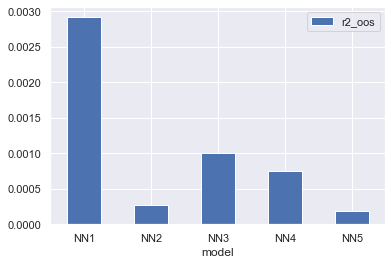

In [12]:
# combine r2_oos 
r2_oos_nn1 = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/r2_OOS_NN1')['NN1_R2oos'].mean()

r2_oos_NN = pd.DataFrame({'model':['NN1','NN2','NN3','NN4','NN5'],
                          'r2_oos':[pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/r2_OOS_NN1')['NN1_R2oos'].mean(),
                                    pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/r2_OOS_NN2')['NN2'].mean(),
                                    pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/r2_OOS_NN3')['NN3'].mean(),
                                    pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/r2_OOS_NN4')['NN4'].mean(),
 
                                    pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/r2_OOS_NN5')['NN5'].mean()]})
# plot r2_oos

ax = r2_oos_NN.plot.bar(x='model', y='r2_oos', rot=0)

In [167]:
predd_result = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/predd_result')

In [168]:
predd_result

,date,permno,real_y,market_cap,NN1_y,NN2_y,NN3_y,NN4_y,NN5_y
0,1992-01-31,50906,0.004831,3.474754e+05,0.005736,0.000073,0.000000,0.001071,0.000000
1,1992-01-31,18980,0.066667,4.353188e+04,0.011863,0.000000,0.000000,0.001752,0.000000
2,1992-01-31,21020,0.003546,4.817054e+06,0.002507,0.000272,0.000000,0.000516,0.000000
3,1992-01-31,27991,0.043165,1.510843e+06,0.002667,0.000069,0.000030,0.001061,0.000000
4,1992-01-31,20482,-0.068966,2.929075e+07,0.001579,0.000000,0.000337,0.002109,0.000000
...,...,...,...,...,...,...,...,...,...
260338,2020-12-31,13210,0.111749,1.804693e+07,0.001564,0.000000,0.000000,0.000000,0.000000
260339,2020-12-31,12981,0.026587,1.160057e+07,0.000000,0.000000,0.000000,0.000362,0.000402
260340,2020-12-31,13035,0.060644,1.729687e+07,0.000586,0.000000,0.000000,0.000000,0.000000
260341,2020-12-31,13168,0.102682,3.177023e+06,0.000000,0.000000,0.000000,0.000000,0.000051


In [322]:
rsquared_df_nn1 = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/rsquared_df_NN1')['NN1'].tolist()
rsquared_df_nn2 = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/rsquared_df_NN2')['NN2'].tolist()
rsquared_df_nn3 = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/rsquared_df_NN3')['NN3'].tolist()
rsquared_df_nn4 = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/rsquared_df_NN4')['NN4'].tolist()
rsquared_df_nn5 = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/result/rsquared_df_NN5')['NN5'].tolist()

In [323]:
rsquared_df_nn1 = [ast.literal_eval(i) for i in rsquared_df_nn1]
rsquared_df_nn2 = [ast.literal_eval(i) for i in rsquared_df_nn2]
rsquared_df_nn3 = [ast.literal_eval(i) for i in rsquared_df_nn3]
rsquared_df_nn4 = [ast.literal_eval(i) for i in rsquared_df_nn4]
rsquared_df_nn5 = [ast.literal_eval(i) for i in rsquared_df_nn5]

In [324]:
rsquared_df_adj = pd.DataFrame(index=X_total.columns[:61])
rsquared_df_adj['NN1'] = rsquared_df_nn1
rsquared_df_adj['NN2'] = rsquared_df_nn2
rsquared_df_adj['NN3'] = rsquared_df_nn3
rsquared_df_adj['NN4'] = rsquared_df_nn4
rsquared_df_adj['NN5'] = rsquared_df_nn5

In [327]:
rsquared_df_adj

,NN1,NN2,NN3,NN4,NN5
adm,"[0.0, 0.005302901297988938, 0.0026079129673981...","[0.0, 0.0002447847193794983, 0.000183954591256...","[0.0, 0.0014307108885304176, 0.000256650478486...","[0.0, 0.0013669238806924833, 0.000661667338024...","[0.0, -3.666826312143101e-06, 0.00025159271891..."
bm_ia,"[0.0, 0.004706356824622282, 0.0021462298914842...","[0.0, 0.00023184589854796656, 0.00021461991029...","[0.0, 0.0014646231430028855, 0.000209232606612...","[0.0, 0.0015546131519018624, 0.000605617916301...","[0.0, -3.961199021906836e-06, 0.00023860890876..."
herf,"[0.0, 0.004933684807712613, 0.0028396704535439...","[0.0, 0.00025501964541019273, 0.00021546388635...","[0.0, 0.0014676901686127009, 0.000246647791992...","[0.0, 0.001184780810151942, 0.0006712863583744...","[0.0, -2.384843589497976e-06, 0.00023620818121..."
hire,"[0.0, 0.005294812136832694, 0.0025781264027423...","[0.0, 0.0002419281527384909, 0.000183889254230...","[0.0, 0.0014078065159339737, 0.000265175905879...","[0.0, 0.0013204967716218263, 0.000652816361857...","[0.0, -3.3748536973909893e-06, 0.0002285509619..."
me_ia,"[0.0, 0.005032180327051883, 0.0024965203933999...","[0.0, 0.00023535010364850173, 0.00017726025294...","[0.0, 0.00133652871525769, 0.00027400794542220...","[0.0, 0.001314726946697542, 0.0006164397117184...","[0.0, -3.5644245088839455e-06, 0.0002426031431..."
...,...,...,...,...,...
roa,"[0.0, 0.005390160818411038, 0.0024452962223102...","[0.0, 0.00022740656658359892, 0.00018849589541...","[0.0, 0.0014391858962715665, 0.000272782787532...","[0.0, 0.001276430515091298, 0.0006099020663338...","[0.0, -3.161990004052484e-06, 0.00020087190215..."
roe,"[0.0, 0.005332330782915284, 0.0025677343158126...","[0.0, 0.00024185669602250215, 0.00018072133995...","[0.0, 0.0014092735419405367, 0.000259729091678...","[0.0, 0.0013198170756411054, 0.000652748770744...","[0.0, -3.40401856324668e-06, 0.000227439631783..."
rsup,"[0.0, 0.005278288777585405, 0.0025646362841268...","[0.0, 0.00023313258541313164, 0.00018655472982...","[0.0, 0.001404261011142327, 0.0002569542296616...","[0.0, 0.001342455093050976, 0.0006356034993775...","[0.0, -3.543825607632556e-06, 0.00022820289051..."
sgr,"[0.0, 0.005308761423794661, 0.0025831124612455...","[0.0, 0.00024167399560681702, 0.00018217681255...","[0.0, 0.0014066495946777335, 0.000265615507676...","[0.0, 0.001321215753522842, 0.0006504852512932...","[0.0, -3.245814742758313e-06, 0.00022785071610..."


In [328]:
#调整rsquared_df -- calculate average of rsquared, rsquared reduction, rsquared normalized
for i in rsquared_df_adj.columns:
    rsquared_df_adj[i] = pd.DataFrame(rsquared_df_adj[i].values.tolist()).drop(0,1).values.tolist()
    rsquared_df_adj[i] = rsquared_df_adj[i].apply(np.mean)
    
oos_feature = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=X_total.columns[:61])

for i in range(len(rsquared_df_adj.columns)):
    oos_feature.iloc[:,i] = r2_oos_NN['r2_oos'][i]

rsquared_reduction = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=X_total.columns[:61])
rsquared_normalized = pd.DataFrame(columns=['NN1','NN2','NN3','NN4','NN5'], index=X_total.columns[:61])

for i in ['NN1','NN2','NN3','NN4','NN5']:
    rsquared_reduction[i] = np.abs(oos_feature.loc[:,i] - rsquared_df_adj.loc[:,i])
    rsquared_normalized[i] = rsquared_reduction.loc[:,i] / rsquared_reduction.loc[:,i].sum()

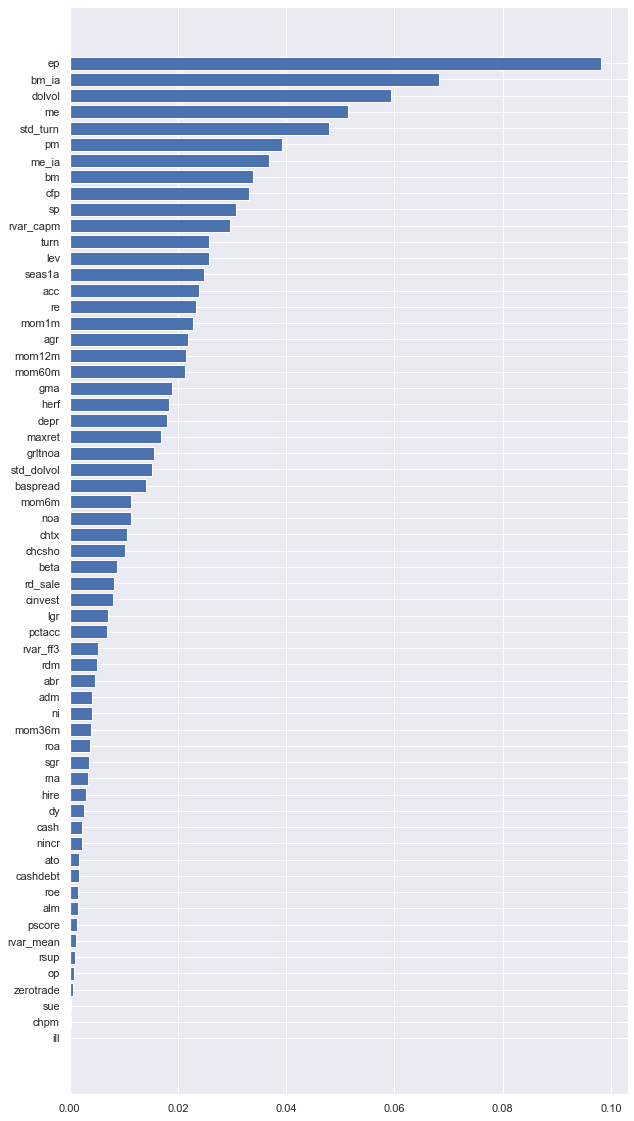

In [329]:
# plot features importance
NN1_FI = pd.DataFrame(rsquared_normalized['NN1'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN1_FI.index, NN1_FI['NN1'])
plt.show()

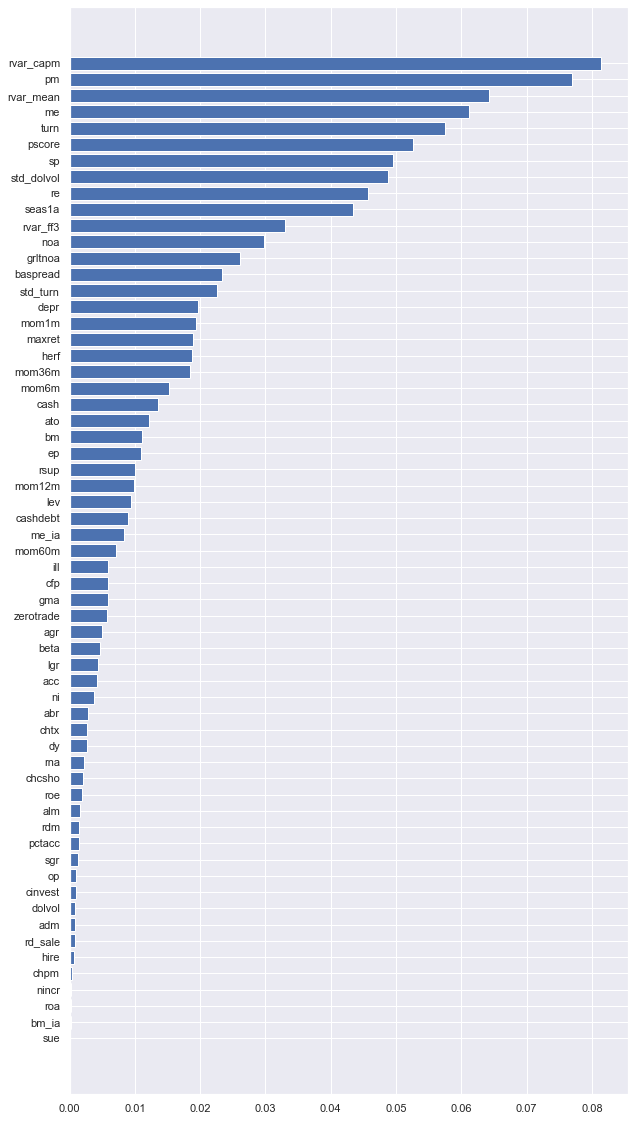

In [330]:
NN2_FI = pd.DataFrame(rsquared_normalized['NN2'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN2_FI.index, NN2_FI['NN2'])
plt.show()

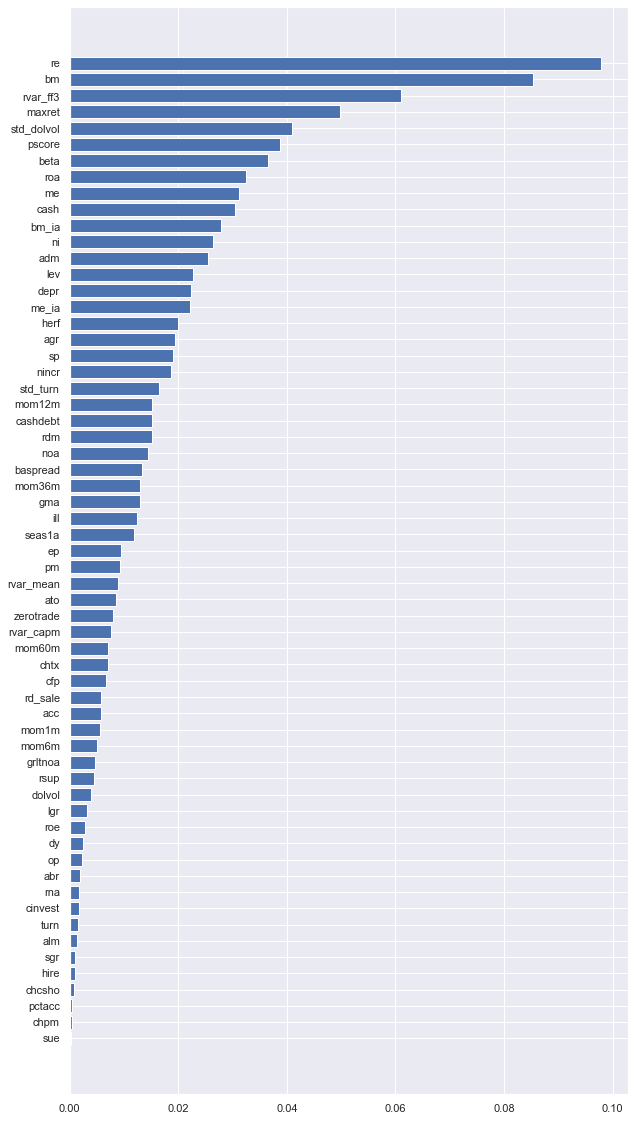

In [331]:
NN3_FI = pd.DataFrame(rsquared_normalized['NN3'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN3_FI.index, NN3_FI['NN3'])
plt.show()

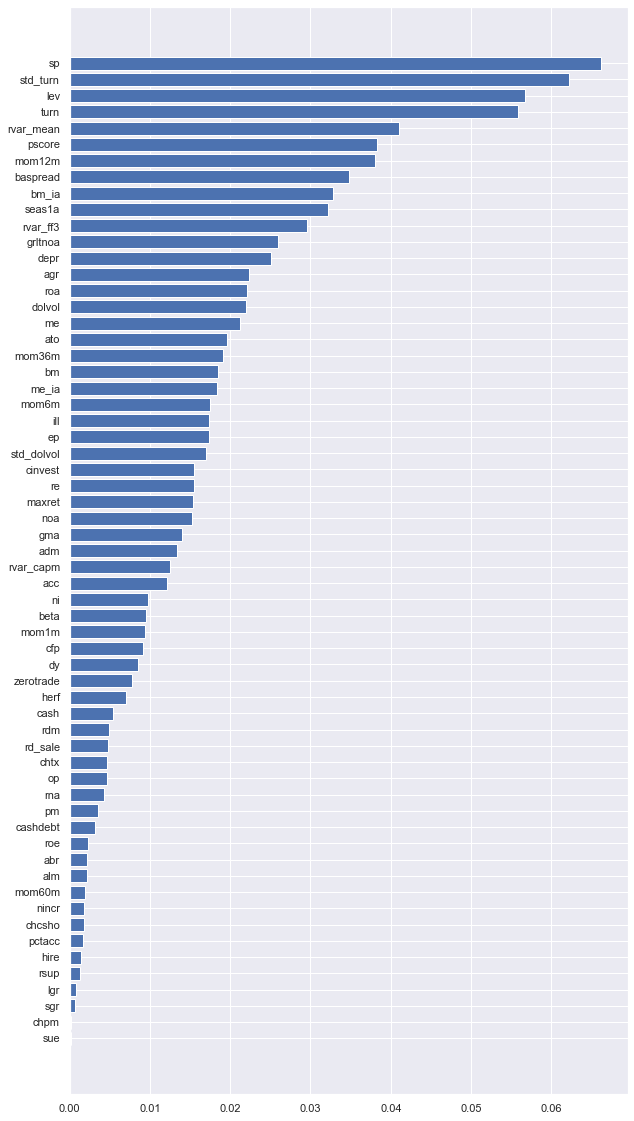

In [332]:
NN4_FI = pd.DataFrame(rsquared_normalized['NN4'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN4_FI.index, NN4_FI['NN4'])
plt.show()

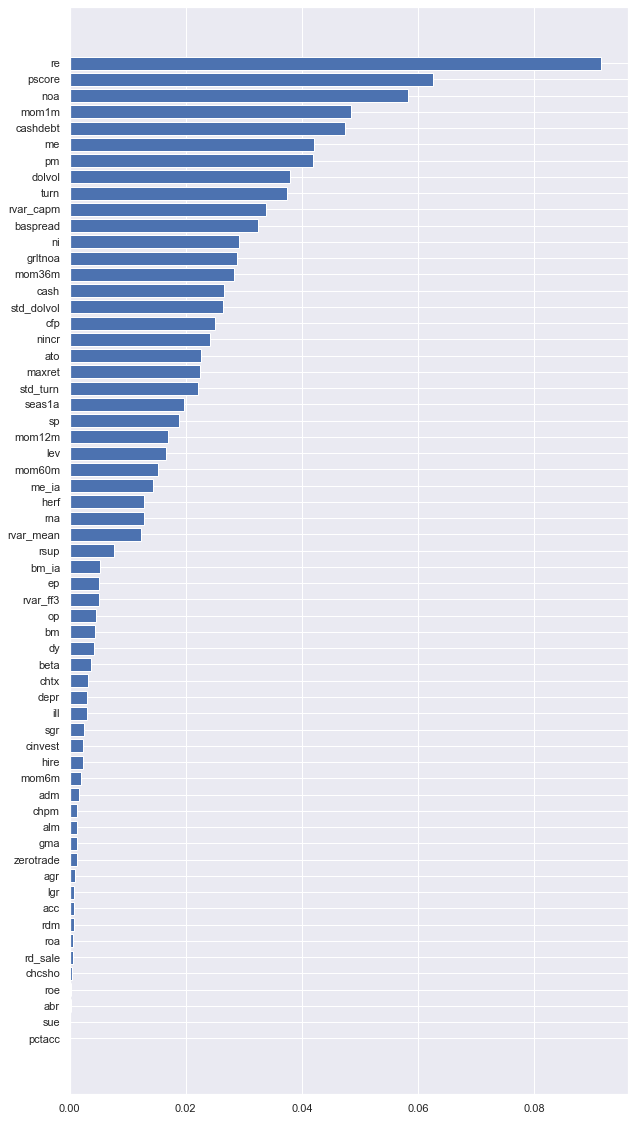

In [333]:
NN5_FI = pd.DataFrame(rsquared_normalized['NN5'].sort_values(ascending=True))

plt.figure(figsize=(10, 20))
plt.barh(NN5_FI.index, NN5_FI['NN5'])
plt.show()

## portfolio construction

In [352]:
NN1_pred_result = predd_result. iloc[:, [0,1,2,3,4]]
NN1_pred_result = NN1_pred_result.set_index('date')

In [353]:
# for each month, lable top-30% return stock as 1, middle as 0, and bottom-30% return as -1 based on real return

date_list = NN1_pred_result.index.drop_duplicates()
NN1_pred_result_adj = pd.DataFrame()

for i in tqdm(date_list):
    df = NN1_pred_result[NN1_pred_result.index == i]
    df=df.assign(type = '')
    real_y_list = df['real_y'].to_list()
    
    top = heapq.nlargest(round(0.3 * len(real_y_list)), real_y_list)
    bottom = heapq.nsmallest(round(0.3 * len(real_y_list)), real_y_list)
    
    for j in range(len(df['real_y'])):
        if df.iloc[j,df.columns.get_loc('real_y')] in top:
            df.iloc[j,df.columns.get_loc('type')] = 1
        elif df.iloc[j,df.columns.get_loc('real_y')] in bottom:
            df.iloc[j,df.columns.get_loc('type')] = -1
        else:
            df.iloc[j,df.columns.get_loc('type')] = 0
            
    NN1_pred_result_adj = NN1_pred_result_adj.append(df)

100%|█████████████████████████████████████████| 348/348 [00:42<00:00,  8.13it/s]


In [361]:
NN1_pred_result_adj

,permno,real_y,market_cap,NN1_y,type
date,,,,,
1992-01-31,50906,0.004831,3.474754e+05,0.005736,0
1992-01-31,18980,0.066667,4.353188e+04,0.011863,0
1992-01-31,21020,0.003546,4.817054e+06,0.002507,0
1992-01-31,27991,0.043165,1.510843e+06,0.002667,0
1992-01-31,20482,-0.068966,2.929075e+07,0.001579,-1
...,...,...,...,...,...
2020-12-31,13210,0.111749,1.804693e+07,0.001564,1
2020-12-31,12981,0.026587,1.160057e+07,0.000000,0
2020-12-31,13035,0.060644,1.729687e+07,0.000586,0


In [362]:
# build long and shor portfolio, long top 100 stock and short bottom 100 each month based on predicted return 
long_portfolio = NN1_pred_result_adj.groupby(level='date').apply(lambda x: x.sort_values('NN1_y', ascending=False).head(100))
short_portfolio = NN1_pred_result_adj.groupby(level='date').apply(lambda x: x.sort_values('NN1_y', ascending=True).head(100))

long_portfolio = long_portfolio.reset_index(level=0, drop=True)
short_portfolio = short_portfolio.reset_index(level=0, drop=True)

In [363]:
# check stock allocation accuracy for long portfolio 
print(f"The probability of a top stock been allocated in a long portfolio: {sum(long_portfolio['type']==1) / len(long_portfolio)}")
print(f"The probability of a middle stock been allocated in a long portfolio: {sum(long_portfolio['type']==0) / len(long_portfolio)}")
print(f"The probability of a bottom stock been allocated in a long portfolio: {sum(long_portfolio['type']==-1) / len(long_portfolio)}")      

The probability of a top stock been allocated in a long portfolio: 0.34479885057471266
The probability of a middle stock been allocated in a long portfolio: 0.3111781609195402
The probability of a bottom stock been allocated in a long portfolio: 0.34402298850574714


In [364]:
# check stock allocation accuracy for short portfolio 
print(f"The probability of a top stock been allocated in a short portfolio: {sum(short_portfolio['type']==1) / len(short_portfolio)}")
print(f"The probability of a middle stock been allocated in a short portfolio: {sum(short_portfolio['type']==0) / len(short_portfolio)}")
print(f"The probability of a bottom stock been allocated in a short portfolio: {sum(short_portfolio['type']==-1) / len(short_portfolio)}")


The probability of a top stock been allocated in a short portfolio: 0.27632183908045976
The probability of a middle stock been allocated in a short portfolio: 0.43586206896551727
The probability of a bottom stock been allocated in a short portfolio: 0.28781609195402297


In [365]:
# download s&p500 historical data and get monthly return
sp500_data = yf.download(tickers = "^GSPC", start = "1991-12-31", end = "2020-12-31", interval = "1d")
sp500_m_adj_close = sp500_data['Adj Close'].resample('M').ffill()
sp500_m_ret = sp500_m_adj_close.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [379]:
date_list = long_portfolio.index.drop_duplicates()
long_portfolio_adj = pd.DataFrame()

for i in tqdm(date_list):
    df = long_portfolio[long_portfolio.index == i]
    df=df.assign(weight = '')
    total_market_cap = sum(df['market_cap'])
        
    for j in range(len(df['market_cap'])):
        df.iloc[j,df.columns.get_loc('weight')] = df.iloc[j,df.columns.get_loc('market_cap')] / total_market_cap
          
    long_portfolio_adj = long_portfolio_adj.append(df)

100%|█████████████████████████████████████████| 348/348 [00:11<00:00, 31.24it/s]


In [381]:
date_list = short_portfolio.index.drop_duplicates()
short_portfolio_adj = pd.DataFrame()

for i in tqdm(date_list):
    df = short_portfolio[short_portfolio.index == i]
    df=df.assign(weight = '')
    total_market_cap = sum(df['market_cap'])
        
    for j in range(len(df['market_cap'])):
        df.iloc[j,df.columns.get_loc('weight')] = df.iloc[j,df.columns.get_loc('market_cap')] / total_market_cap
          
    short_portfolio_adj = short_portfolio_adj.append(df)

100%|█████████████████████████████████████████| 348/348 [00:11<00:00, 30.45it/s]


In [415]:
long_portfolio_adj[long_portfolio_adj.index == '1992-01-31'].sort_values(by=['weight'],ascending=False)

,permno,real_y,market_cap,NN1_y,type,weight,adj_return
date,,,,,,,
1992-01-31,10107,0.080899,1.972462e+07,0.010569,1,0.141749,0.011467
1992-01-31,66181,-0.085343,1.414309e+07,0.008751,-1,0.101638,-0.008674
1992-01-31,14008,-0.069307,9.988698e+06,0.010477,-1,0.071783,-0.004975
1992-01-31,90609,-0.029167,8.639160e+06,0.012382,0,0.062084,-0.001811
1992-01-31,59010,-0.004673,7.612782e+06,0.012518,0,0.054708,-0.000256
...,...,...,...,...,...,...,...
1992-01-31,22787,0.066667,1.358531e+04,0.008772,0,0.000098,0.000007
1992-01-31,54447,0.200000,1.032125e+04,0.015363,1,0.000074,0.000015
1992-01-31,27836,-0.043478,7.089750e+03,0.015897,-1,0.000051,-0.000002


In [384]:
long_portfolio_adj['adj_return'] = long_portfolio_adj['real_y'] * long_portfolio_adj['weight']
short_portfolio_adj['adj_return'] = short_portfolio_adj['real_y'] * short_portfolio_adj['weight']

In [388]:
# get monthly average return 
port_m_ret = pd.DataFrame()

port_m_ret['long_ret'] = long_portfolio_adj.groupby('date')['adj_return'].apply('mean')
port_m_ret['short_ret'] = short_portfolio_adj.groupby('date')['adj_return'].apply('mean')
port_m_ret['short_ret'] = - port_m_ret['short_ret']
port_m_ret['long_short_ret'] = (port_m_ret['long_ret'] + port_m_ret['short_ret'])/2
port_m_ret['s&p 500'] = sp500_m_ret

port_m_ret.index = pd.to_datetime(port_m_ret.index)

In [389]:
port_m_ret

,long_ret,short_ret,long_short_ret,s&p 500
date,,,,
1992-01-31,0.000264,0.000195,0.000230,-0.019924
1992-02-29,0.000209,-0.000029,0.000090,0.009590
1992-03-31,-0.000476,0.000194,-0.000141,-0.021832
1992-04-30,-0.000445,-0.000567,-0.000506,0.027893
1992-05-31,0.000341,-0.000041,0.000150,0.000964
...,...,...,...,...
2020-08-31,0.000542,-0.000674,-0.000066,0.070065
2020-09-30,-0.000325,0.000271,-0.000027,-0.039228
2020-10-31,-0.000035,0.000424,0.000194,-0.027666


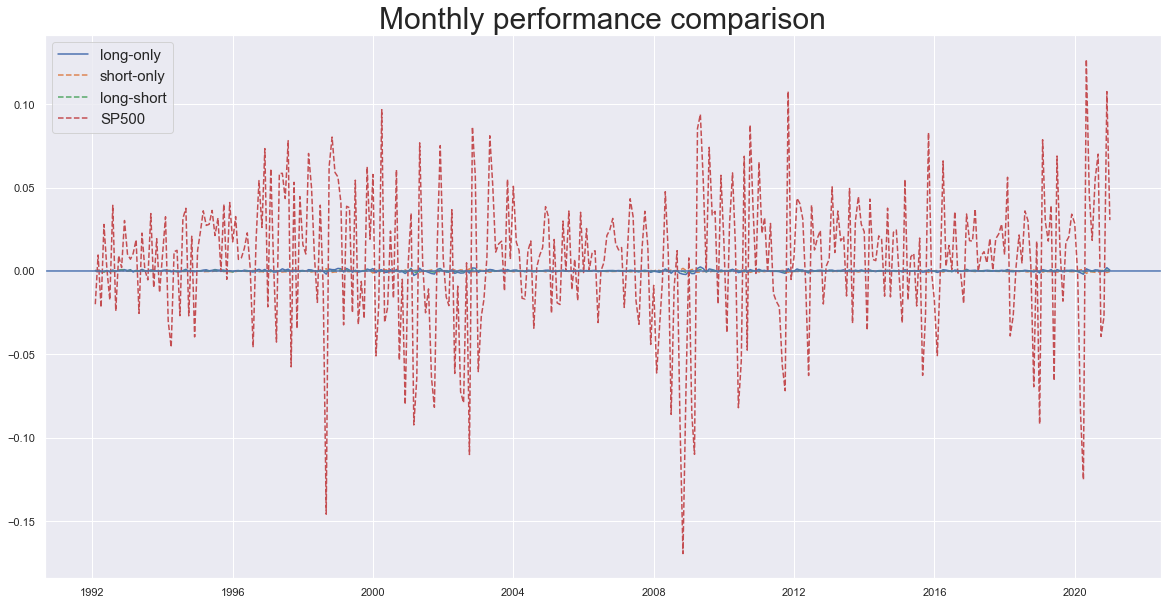

In [390]:
plt.figure(figsize=(20, 10))

plt.plot(port_m_ret['long_ret'], '-', label='long-only');
plt.plot(port_m_ret['short_ret'], '--', label='short-only');
plt.plot(port_m_ret['long_short_ret'], '--', label='long-short');
plt.plot(port_m_ret['s&p 500'], '--', label='SP500');

plt.axhline(0);
plt.title('Monthly performance comparison',fontsize=30)
plt.legend(fontsize=15);

In [385]:
long_portfolio_adj

,permno,real_y,market_cap,NN1_y,type,weight,adj_return
date,,,,,,,
1992-01-31,18278,0.200000,6.051406e+03,0.164349,1,0.000043,0.000009
1992-01-31,41515,0.487179,4.988100e+04,0.042507,1,0.000358,0.000175
1992-01-31,88031,-0.125000,1.803000e+04,0.033341,-1,0.00013,-0.000016
1992-01-31,19131,0.000000,9.082450e+04,0.029094,0,0.000653,0.0
1992-01-31,40352,0.400000,3.793500e+04,0.026139,1,0.000273,0.000109
...,...,...,...,...,...,...,...
2020-12-31,85753,0.078119,2.290416e+07,0.001942,0,0.006002,0.000469
2020-12-31,90038,0.054988,7.659140e+06,0.001940,0,0.002007,0.00011
2020-12-31,11786,0.124601,1.786271e+07,0.001930,1,0.004681,0.000583


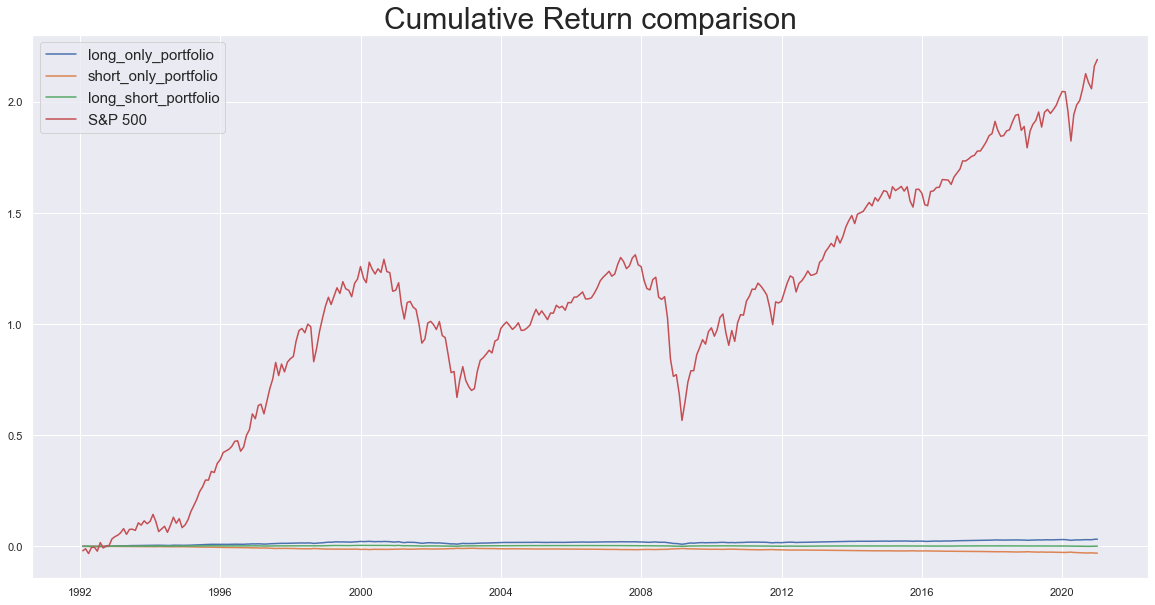

In [391]:
# get cumulative log return 
port_ret_cum = (np.log(port_m_ret+1)).cumsum()
# port_ret_cum = port_m_ret.cumsum()


plt.figure(figsize=(20, 10))
plt.plot(port_ret_cum)
plt.title('Cumulative Return comparison',fontsize=30)
plt.legend(['long_only_portfolio','short_only_portfolio','long_short_portfolio','S&P 500'],fontsize=15)

In [104]:
# annualized sharpe ratio
sharp_ratio = (port_m_ret.mean() / port_m_ret.std()) * np.sqrt(12)
sharp_ratio

long_ret          0.871129
short_ret         0.891503
long_short_ret    0.921811
s&p 500           0.596034
dtype: float64

## parameter

In [123]:
data = rolling1
train_x = data[0]
train_y = data[1]
valid_x = data[2]
valid_y = data[3]
test_x = data[4]
test_y = data[5]
    
temp_preddf = pd.DataFrame() 
temp_preddf['real_y'] = test_y.iloc[:,0]
    
regr_NN1 = KerasRegressor(NN1)
# regr_NN1.fit(train_x, train_y, epochs=100,
#                  validation_data=(valid_x, valid_y), 
#                  callbacks=callback, 
#                  batch_size=10000)
    
# predict_yNN1 = regr_NN1.predict(test_x)
# temp_preddf['NN1_y'] = predict_yNN1

C:\Users\haosh\AppData\Local\Temp\ipykernel_12676\1672158916.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regr_NN1 = KerasRegressor(NN1)


In [126]:
def parm_tuning(train_x, train_y, valid_x, valid_y, regr_NN1):
    
    params ={
        'epochs': np.arange(10, 100,10),
        'batch_size': np.arange(500, 10000,500),
        'learning_rate':uniform(loc=0.001, scale = 0.05),
        'k_reg': [10e-5,10e-3]
    }
    
    r2oos_score = make_scorer(r2_oos, greater_is_better=True)
    scoring_dict = {'r2_oos':r2oos_score, 'mse':'neg_mean_squared_error'}

    grid = RandomizedSearchCV(model, params, n_iter=15, cv=3, verbose=2, scoring= scoring_dict, refit ='r2_oos')

    grid.fit(train_x, train_y,
             validation_data=(valid_x, valid_y),
            callbacks=callback)
    
    return grid

In [ ]:
NN1_search_cv= (train_x, train_y, valid_x, valid_y, regr_NN1)

# print(NN1_search_cv.best_params_)
regr_NN1_mod = NN1_search_cv.best_estimator_.model
regr_NN1_mod.fit(train_x, train_y,
                  validation_data=(valid_x, valid_y),
                  callbacks=callback)

preddf_NN1['NN1_y_best'] = regr_NN1_mod.predict(test_x)
r2_oos(preddf_NN1['NN1_y_best'],preddf_NN1['real_y'])